# 生产企业原材料的订购与运输
## 分析
一年48周，需提前24周制定订购转运计划，每周产能为2.82万 $m^3$ 
### 原材料：
- **A:** 消耗量 $0.6 m^3 / m^3$ ，单价 $120\%$
- **B:** 消耗量 $0.66 m^3 / m^3$ ，单价 $110\%$
- **C:** 消耗量 $0.72 m^3 / m^3$ ，单价 $100\%$

- 附件 1 给出了该企业近 5 年 402 家原材料供应商的订货量和供货量数据。
- 附件 2 给出了 8 家转运商的运输损耗率数据。

## 计算并解决问题1

### 初始化环境

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['黑体', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("done!")

done!


### 数据读取和简单处理

In [2]:
# ==================== 数据读取与预处理 ====================
print("="*60)
print("步骤1：读取附件1和附件2数据")
print("="*60)

try:
    # 读取附件1：供应商数据
    supplier_order = pd.read_excel('C/附件1 近5年402家供应商的相关数据.xlsx', 
                                   sheet_name='企业的订货量（m³）')
    supplier_supply = pd.read_excel('C/附件1 近5年402家供应商的相关数据.xlsx', 
                                    sheet_name='供应商的供货量（m³）')
    
    # 读取附件2：转运商数据
    transporter_loss = pd.read_excel('C/附件2 近5年8家转运商的相关数据.xlsx', 
                                     sheet_name='运输损耗率（%）')
    
    print("数据读取成功!")
    print(f"  - 供应商订货量数据: {supplier_order.shape}")
    print(f"  - 供应商供货量数据: {supplier_supply.shape}")
    print(f"  - 转运商损耗率数据: {transporter_loss.shape}")
    
except Exception as e:
    print(f"数据读取失败: {e}")
    print("请确保数据文件路径正确！")

步骤1：读取附件1和附件2数据
数据读取成功!
  - 供应商订货量数据: (402, 242)
  - 供应商供货量数据: (402, 242)
  - 转运商损耗率数据: (8, 241)


In [3]:
# ==================== 附件1数据结构分析 ====================
print("\n" + "="*60)
print("步骤2：附件1数据结构分析")
print("="*60)

# 查看数据前几行
print("供应商订货量数据结构:")
print(supplier_order.head())

print("\n供应商供货量数据结构:")
print(supplier_supply.head())

# 提取关键信息
supplier_names = supplier_order.iloc[:, 0].values  # 供应商名称
material_types = supplier_order.iloc[:, 1].values  # 材料类型
order_data = supplier_order.iloc[:, 2:].values     # 订货量数据
supply_data = supplier_supply.iloc[:, 2:].values   # 供货量数据

print(f"\n基本统计信息:")
print(f"  - 供应商总数: {len(supplier_names)}")
print(f"  - 数据周期: {order_data.shape[1]} 周")
print(f"  - 原材料类型分布:")

# 分析材料类型分布
material_counts = pd.Series(material_types).value_counts()
for material, count in material_counts.items():
    percentage = count / len(material_types) * 100
    print(f"    * {material}类: {count}家 ({percentage:.1f}%)")

print(f"\n数据质量检查:")
print(f"  - 订货量数据缺失值: {pd.isna(order_data).sum().sum()}")
print(f"  - 供货量数据缺失值: {pd.isna(supply_data).sum().sum()}")
print(f"  - 订货量数据零值比例: {(order_data == 0).sum().sum() / order_data.size * 100:.1f}%")
print(f"  - 供货量数据零值比例: {(supply_data == 0).sum().sum() / supply_data.size * 100:.1f}%")


步骤2：附件1数据结构分析
供应商订货量数据结构:
  供应商ID 材料分类  W001  W002  W003  W004  W005  W006  W007  W008  ...  W231  W232  \
0  S001    B     0     0     0    43     0     0     0     0  ...     1     0   
1  S002    A     1     1     0     1     0     0     0     0  ...     0     0   
2  S003    C     7     1     0     0     0     1     4    50  ...    10     3   
3  S004    B     0     1     1   100     0    85     0     0  ...     1     0   
4  S005    A    30    60    60    60    70    70    60    70  ...    80    70   

   W233  W234  W235  W236  W237  W238  W239  W240  
0     0     1     0     1     0     0     0     0  
1     1     0     0     0     1     1     0     1  
2    50    20    20     7    10     9    20    10  
3     1     0     0     0     0     1     0     0  
4    70    70    70    70    70    70    70    80  

[5 rows x 242 columns]

供应商供货量数据结构:
  供应商ID 材料分类  W001  W002  W003  W004  W005  W006  W007  W008  ...  W231  W232  \
0  S001    B     0     0     0     0     0     0     0  

### 转运商T1-T8运输损耗率分布图

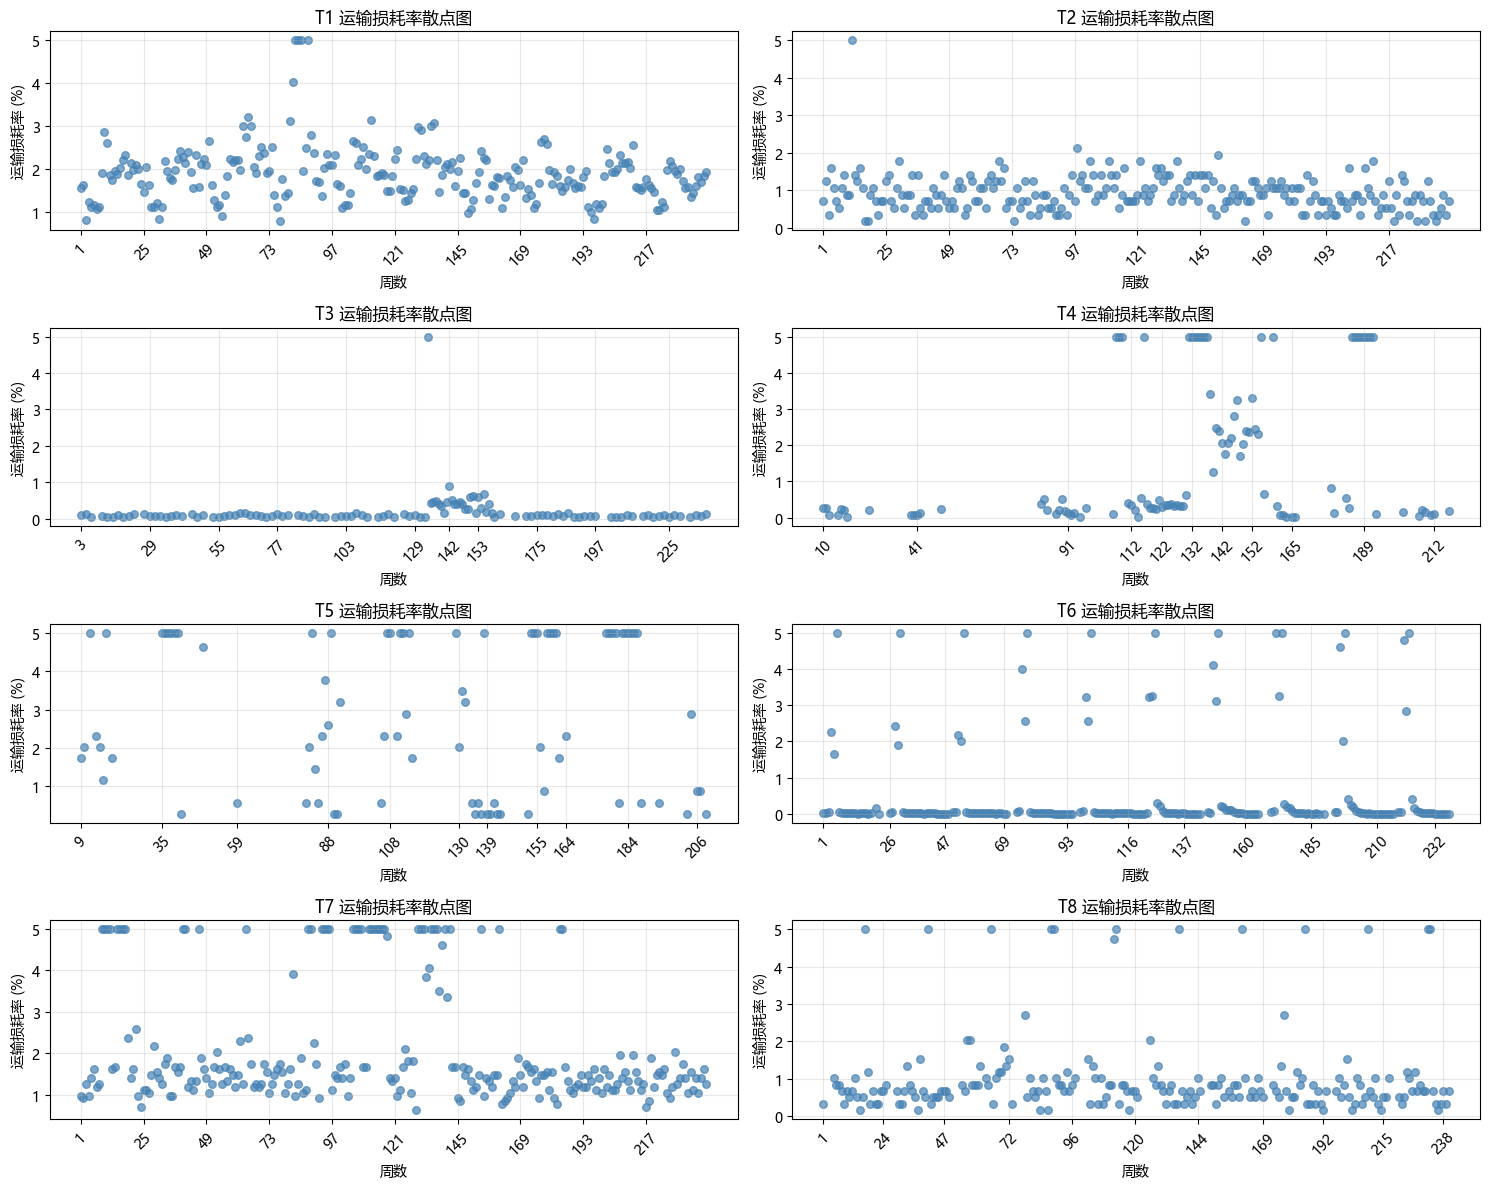

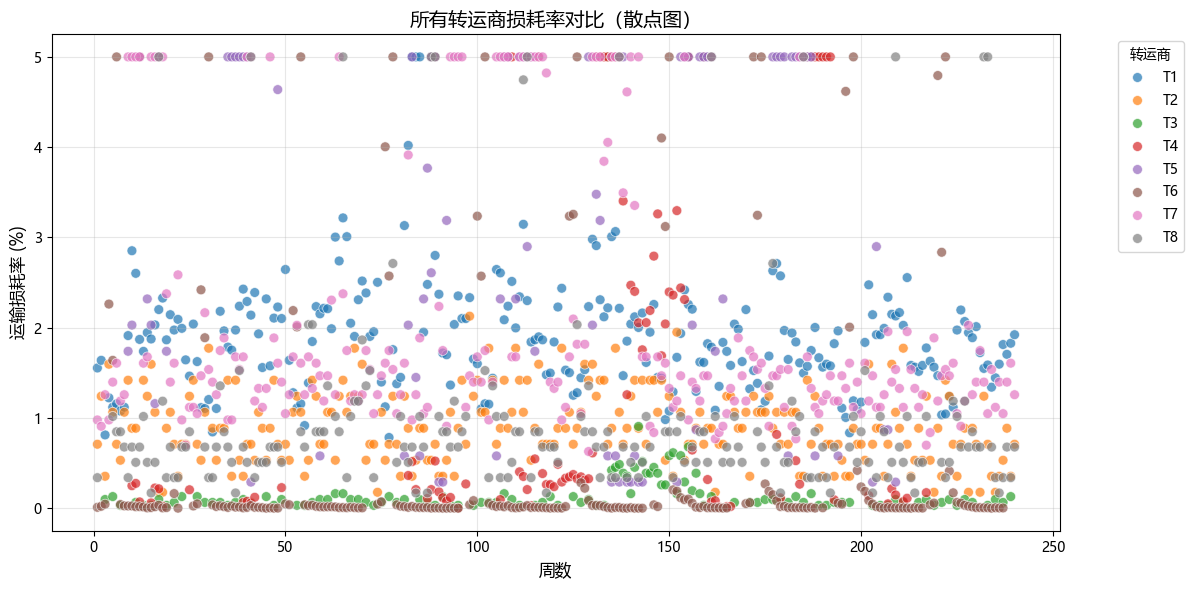

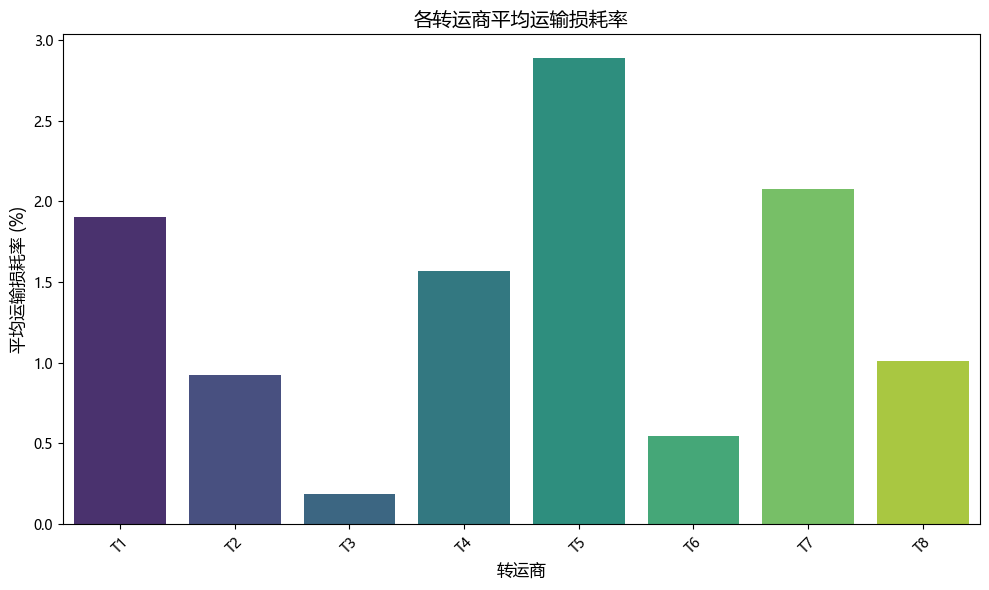

In [4]:
# 绘制转运商T1-T8的损耗率分布图
# 横坐标为周数，纵坐标为运输损耗率（%），每个转运商单独画一张图
fig, axes = plt.subplots(4, 2, figsize=(15, 12))

# 获取周数（列索引）
weeks = range(1, transporter_loss.shape[1])  # 从第2列开始是数据列

transporter_loss_mean = []
for i, transporter_name in enumerate(transporter_loss.iloc[:, 0]):  # 第一列是转运商名称
    row, col = divmod(i, 2)
    
    # 获取该转运商的损耗率数据（排除第一列的名称列）
    loss_rates = transporter_loss.iloc[i, 1:].values
    
    # 过滤掉值为0的点
    non_zero_mask = loss_rates > 0
    filtered_weeks = [w for w, mask in zip(weeks, non_zero_mask) if mask]
    filtered_loss_rates = loss_rates[non_zero_mask]
    
    transporter_loss_mean.append(filtered_loss_rates.mean() if len(filtered_loss_rates) > 0 else 0)
    # 绘制散点图，只绘制非零值
    axes[row, col].scatter(filtered_weeks, filtered_loss_rates, alpha=0.7, s=30, color='steelblue')
    axes[row, col].set_title(f"{transporter_name} 运输损耗率散点图", fontsize=12)
    axes[row, col].set_xlabel("周数", fontsize=10)
    axes[row, col].set_ylabel("运输损耗率 (%)", fontsize=10)
    axes[row, col].grid(True, alpha=0.3)
    
    # 设置x轴标签间隔，避免过于密集
    axes[row, col].tick_params(axis='x', rotation=45)
    if len(filtered_weeks) > 20:
        # 如果周数太多，只显示部分刻度
        step = max(1, len(filtered_weeks) // 10)
        axes[row, col].set_xticks(filtered_weeks[::step])

# 调整布局并保存为矢量图（必须在show()之前）
plt.tight_layout()
plt.savefig('transporter_loss_scatter.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# 额外：使用seaborn绘制所有转运商在一张图上的对比（散点图）
plt.figure(figsize=(12, 6))

# 创建长格式数据用于seaborn，只包含非零值
transporter_long = []

for i, transporter_name in enumerate(transporter_loss.iloc[:, 0]):
    for week, loss_rate in enumerate(transporter_loss.iloc[i, 1:].values, 1):
        if loss_rate > 0:  # 只包含非零值
            transporter_long.append({
                'transporter': transporter_name,
                'week': week,
                'loss_rate': loss_rate
            })

df_long = pd.DataFrame(transporter_long)

# 使用seaborn绘制散点图
sns.scatterplot(data=df_long, x='week', y='loss_rate', hue='transporter', 
                alpha=0.7, s=50)
plt.title('所有转运商损耗率对比（散点图）', fontsize=14)
plt.xlabel('周数', fontsize=12)
plt.ylabel('运输损耗率 (%)', fontsize=12)
plt.legend(title='转运商', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('transporter_comparison_scatter.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

# 绘制平均损耗率条形图
plt.figure(figsize=(10, 6))
sns.barplot(x=transporter_loss.iloc[:, 0], y=transporter_loss_mean, palette='viridis')
plt.title('各转运商平均运输损耗率', fontsize=14)
plt.xlabel('转运商', fontsize=12)
plt.ylabel('平均运输损耗率 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('transporter_average_loss.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

### 分别计算每个供货商每周参数
1. 市场占有率（该供货商占此类型原材料的市场份额）
2. 有效供货率（订单满足率）


#### 市场占有率和有效供货率计算方法说明

##### 核心计算公式

###### 1. 市场占有率计算
**周市场占有率（基于订货量）**
```
周市场占有率[i] = 该供应商第i周订货量 / 该材料类型所有供应商第i周总订货量
```

**周市场占有率（基于供货量）**
```
周市场占有率[i] = 该供应商第i周供货量 / 该材料类型所有供应商第i周总供货量
```

**总市场占有率**
```
总市场占有率 = 该供应商总订货量(或供货量) / 该材料类型所有供应商总订货量(或总供货量)
```

###### 2. 有效供货率计算
**周有效供货率**
```
周有效供货率[i] = 该供应商第i周实际供货量 / 该供应商第i周订货量
```

**总有效供货率**
```
总有效供货率 = 该供应商总实际供货量 / 该供应商总订货量
```

###### 3. 平均值计算
- **平均市场占有率**：只考虑有订货/供货的周数，避免0值影响
- **平均有效供货率**：只考虑有订货的周数

##### 计算步骤
1. **数据分组**：按材料类型（A/B/C）分组所有供应商
2. **市场总量计算**：计算每种材料每周的总订货量和总供货量
3. **逐供应商计算**：计算每个供应商的各项指标
4. **结果存储**：将所有指标保存到字典中供后续分析


In [5]:
# ==================== 供应商供货特征分析 ====================
print("\n" + "="*60)
print("步骤3：供应商供货特征深度分析")
print("="*60)

# 计算每个供应商的关键指标
def analyze_supplier_characteristics():
    """
    分析每个供应商的供货特征
    
    返回：包含所有供应商特征指标的DataFrame
    计算指标：可靠性、稳定性、供货频率、平均周供货量、最大周供货量等
    """
    
    supplier_metrics = []
    
    # 遍历每个供应商进行特征分析
    for i in range(len(supplier_names)):
        # 步骤1：获取基本数据
        orders = order_data[i]      # 该供应商的订货量时间序列
        supplies = supply_data[i]   # 该供应商的供货量时间序列
        
        # 步骤2：数据预处理 - 过滤非零数据用于计算平均值和稳定性
        non_zero_orders = orders[orders > 0]    # 过滤掉零订货量的周数
        non_zero_supplies = supplies[supplies > 0]  # 过滤掉零供货量的周数
        
        # 步骤3：计算总量指标
        total_order = np.sum(orders)    # 总订货量：累计所有周的订货量
        total_supply = np.sum(supplies) # 总供货量：累计所有周的供货量
        
        # 步骤4：计算供货可靠性
        # 公式：reliability = 总实际供货量 / 总订货量
        # 含义：反映供应商整体的订单完成能力，值越接近1越好
        reliability = total_supply / total_order if total_order > 0 else 0
        
        # 步骤5：计算供货稳定性
        # 使用变异系数的倒数来衡量稳定性
        # 变异系数 = 标准差 / 平均值，值越小越稳定
        # 稳定性 = 1 / (变异系数 + 0.001)，值越大越稳定
        if len(non_zero_supplies) > 0:
            supply_cv = np.std(non_zero_supplies) / np.mean(non_zero_supplies)  # 计算变异系数
        else:
            supply_cv = float('inf')  # 无供货记录时设为无穷大
        stability = 1 / (supply_cv + 0.001)  # 转换为稳定性指标，加0.001避免除零
        
        # 步骤6：计算供货频率
        # 公式：supply_frequency = 有供货的周数 / 总周数
        # 含义：反映供应商的活跃程度，值越大说明供货越频繁
        supply_frequency = len(non_zero_supplies) / len(supplies)
        
        # 步骤7：计算平均周供货量
        # 只计算有供货周数的平均值，避免零值影响
        avg_weekly_supply = np.mean(non_zero_supplies) if len(non_zero_supplies) > 0 else 0
        
        # 步骤8：计算最大周供货量
        # 反映供应商的最大供货能力
        max_weekly_supply = np.max(supplies)
        
        # 步骤9：汇总所有指标
        supplier_metrics.append({
            'supplier_name': supplier_names[i],        # 供应商名称
            'material_type': material_types[i],        # 材料类型(A/B/C)
            'total_order': total_order,                # 总订货量
            'total_supply': total_supply,              # 总供货量
            'reliability': reliability,                # 供货可靠性(0-1)
            'stability': stability,                    # 供货稳定性(值越大越稳定)
            'supply_frequency': supply_frequency,      # 供货频率(0-1)
            'avg_weekly_supply': avg_weekly_supply,    # 平均周供货量
            'max_weekly_supply': max_weekly_supply,    # 最大周供货量
            'active_weeks': len(non_zero_supplies)     # 有效供货周数
        })
    
    # 步骤10：返回DataFrame格式的结果
    return pd.DataFrame(supplier_metrics)

# 执行供应商特征分析
supplier_analysis = analyze_supplier_characteristics()

print("\n供应商供货特征分析完成！")
print(f"分析了 {len(supplier_analysis)} 家供应商的供货特征")
print("包含指标：可靠性、稳定性、供货频率、平均周供货量、最大周供货量等")

def calculate_market_share_and_fulfillment():
    """
    计算每个供应商的市场占有率和有效供货率
    
    市场占有率计算公式：
    - 周市场占有率 = 该供应商某周订货量(或供货量) / 该材料类型所有供应商该周总订货量(或总供货量)
    - 总市场占有率 = 该供应商总订货量(或供货量) / 该材料类型所有供应商总订货量(或总供货量)
    
    有效供货率计算公式：
    - 周有效供货率 = 该供应商某周实际供货量 / 该供应商某周订货量
    - 总有效供货率 = 该供应商总实际供货量 / 该供应商总订货量
    """
    # 步骤1：初始化数据结构
    # 创建结果字典存储每个供应商的指标
    supplier_metrics = {}
    
    # 步骤2：按材料类型分组数据
    # 分离三种材料的数据，便于按材料类型计算市场占有率
    material_data = {'A': [], 'B': [], 'C': []}
    
    # 按材料类型分组数据：将每个供应商的数据归类到对应的材料类型中
    for i, material_type in enumerate(material_types):
        material_data[material_type].append({
            'supplier_name': supplier_names[i],
            'order_data': order_data[i],      # 该供应商的周订货量数组
            'supply_data': supply_data[i],    # 该供应商的周供货量数组
            'index': i
        })
    
    print("各材料类型供应商数量统计:")
    for material in ['A', 'B', 'C']:
        print(f"  {material}类材料供应商: {len(material_data[material])}家")
    
    # 步骤3：计算市场总量（分母）
    # 计算每种材料每周的总订货量和总供货量，用于计算市场占有率
    weekly_totals = {}
    for material in ['A', 'B', 'C']:
        suppliers = material_data[material]
        # 初始化该材料类型的周总量数组（长度为总周数）
        weekly_order_total = np.zeros(order_data.shape[1])
        weekly_supply_total = np.zeros(supply_data.shape[1])
        
        # 累加所有供应商的订货量和供货量，得到每周市场总量
        for supplier in suppliers:
            weekly_order_total += supplier['order_data']   # 周订货量累加
            weekly_supply_total += supplier['supply_data'] # 周供货量累加
        
        # 存储该材料类型的市场总量数据
        weekly_totals[material] = {
            'order_total': weekly_order_total,   # 每周总订货量数组
            'supply_total': weekly_supply_total  # 每周总供货量数组
        }
    
    # 步骤4：逐个供应商计算指标
    # 计算每个供应商的各项指标
    for material in ['A', 'B', 'C']:
        suppliers = material_data[material]
        
        for supplier in suppliers:
            supplier_name = supplier['supplier_name']
            orders = supplier['order_data']    # 该供应商的周订货量数组
            supplies = supplier['supply_data'] # 该供应商的周供货量数组
            
            # 计算步骤1：每周市场占有率（基于订货量）
            # 公式：weekly_market_share_order[i] = orders[i] / weekly_totals[material]['order_total'][i]
            # 使用np.divide避免除零错误，当分母为0时结果为0
            weekly_market_share_order = np.divide(
                orders,                                      # 分子：该供应商各周订货量
                weekly_totals[material]['order_total'],      # 分母：该材料类型各周总订货量
                out=np.zeros_like(orders, dtype=float),      # 除零时的输出值
                where=weekly_totals[material]['order_total']!=0  # 只在分母非零时计算
            )
            
            # 计算步骤2：每周市场占有率（基于供货量）
            # 公式：weekly_market_share_supply[i] = supplies[i] / weekly_totals[material]['supply_total'][i]
            weekly_market_share_supply = np.divide(
                supplies,                                    # 分子：该供应商各周供货量
                weekly_totals[material]['supply_total'],     # 分母：该材料类型各周总供货量
                out=np.zeros_like(supplies, dtype=float),    # 除零时的输出值
                where=weekly_totals[material]['supply_total']!=0  # 只在分母非零时计算
            )
            
            # 计算步骤3：总市场占有率
            # 先计算总量，再计算占比
            total_order = np.sum(orders)                     # 该供应商总订货量
            total_supply = np.sum(supplies)                  # 该供应商总供货量
            total_market_order = np.sum(weekly_totals[material]['order_total'])   # 该材料类型总订货量
            total_market_supply = np.sum(weekly_totals[material]['supply_total']) # 该材料类型总供货量
            
            # 公式：total_market_share_order = total_order / total_market_order
            total_market_share_order = total_order / total_market_order if total_market_order > 0 else 0
            # 公式：total_market_share_supply = total_supply / total_market_supply
            total_market_share_supply = total_supply / total_market_supply if total_market_supply > 0 else 0
            
            # 计算步骤4：每周有效供货率（订单满足率）
            # 公式：weekly_fulfillment_rate[i] = supplies[i] / orders[i]
            # 表示该供应商每周实际供货量占其订货量的比例
            weekly_fulfillment_rate = np.divide(
                supplies,                                    # 分子：该供应商各周实际供货量
                orders,                                      # 分母：该供应商各周订货量
                out=np.zeros_like(supplies, dtype=float),    # 除零时的输出值
                where=orders!=0                              # 只在订货量非零时计算
            )
            
            # 计算步骤5：总有效供货率
            # 公式：total_fulfillment_rate = total_supply / total_order
            # 表示该供应商总体实际供货量占其总订货量的比例
            total_fulfillment_rate = total_supply / total_order if total_order > 0 else 0
            
            # 计算步骤6：计算平均市场占有率和有效供货率
            # 只考虑有订货的周数，避免空周对平均值的影响
            active_weeks = orders > 0                        # 找出有订货的周数（布尔数组）
            
            # 平均市场占有率（基于订货量）：只计算有订货周数的平均值
            # 公式：avg_market_share_order = mean(weekly_market_share_order[active_weeks])
            avg_market_share_order = np.mean(weekly_market_share_order[active_weeks]) if np.any(active_weeks) else 0
            
            # 平均市场占有率（基于供货量）：只计算有供货周数的平均值
            # 公式：avg_market_share_supply = mean(weekly_market_share_supply[supplies > 0])
            avg_market_share_supply = np.mean(weekly_market_share_supply[supplies > 0]) if np.any(supplies > 0) else 0
            
            # 平均有效供货率：只计算有订货周数的平均值
            # 公式：avg_fulfillment_rate = mean(weekly_fulfillment_rate[active_weeks])
            avg_fulfillment_rate = np.mean(weekly_fulfillment_rate[active_weeks]) if np.any(active_weeks) else 0
            
            # 步骤7：存储计算结果
            # 将所有计算得到的指标存储到字典中，便于后续分析使用
            supplier_metrics[supplier_name] = {
                'material_type': material,                    # 材料类型（A/B/C）
                'weekly_market_share_order': weekly_market_share_order,     # 周市场占有率（基于订货量）数组
                'weekly_market_share_supply': weekly_market_share_supply,   # 周市场占有率（基于供货量）数组
                'weekly_fulfillment_rate': weekly_fulfillment_rate,         # 周有效供货率数组
                'total_market_share_order': total_market_share_order,       # 总市场占有率（基于订货量）
                'total_market_share_supply': total_market_share_supply,     # 总市场占有率（基于供货量）
                'total_fulfillment_rate': total_fulfillment_rate,           # 总有效供货率
                'avg_market_share_order': avg_market_share_order,           # 平均市场占有率（基于订货量）
                'avg_market_share_supply': avg_market_share_supply,         # 平均市场占有率（基于供货量）
                'avg_fulfillment_rate': avg_fulfillment_rate,               # 平均有效供货率
                'total_order': total_order,                                 # 总订货量
                'total_supply': total_supply,                               # 总供货量
                'active_weeks_count': np.sum(active_weeks)                  # 有效供货周数
            }
    
    # 步骤8：返回计算结果
    # 返回所有供应商的指标字典和各材料类型的市场总量数据
    return supplier_metrics, weekly_totals

# 执行计算
supplier_metrics, weekly_totals = calculate_market_share_and_fulfillment()

print("\n市场占有率和供货率计算完成!")

# 显示各材料类型的市场总体情况
print("\n各材料类型市场总体情况:")
for material in ['A', 'B', 'C']:
    total_order = np.sum(weekly_totals[material]['order_total'])
    total_supply = np.sum(weekly_totals[material]['supply_total'])
    overall_fulfillment = total_supply / total_order if total_order > 0 else 0
    
    print(f"  {material}类材料:")
    print(f"    - 总订货量: {total_order:,.0f} m³")
    print(f"    - 总供货量: {total_supply:,.0f} m³")
    print(f"    - 整体满足率: {overall_fulfillment:.3f} ({overall_fulfillment*100:.1f}%)")

# 显示各材料类型排名前10的供应商
print("\n各材料类型市场占有率TOP 10供应商:")
for material in ['A', 'B', 'C']:
    print(f"\n{material}类材料（按总市场占有率排序）:")
    material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                         if metrics['material_type'] == material]
    material_suppliers.sort(key=lambda x: x[1]['total_market_share_order'], reverse=True)
    
    print(f"{'排名':<4} {'供应商':<12} {'总市场占有率':<12} {'总供货率':<10} {'平均供货率':<10}")
    print("-" * 60)
    
    for i, (name, metrics) in enumerate(material_suppliers[:10], 1):
        print(f"{i:<4} {name:<12} {metrics['total_market_share_order']*100:<12.2f}% "
              f"{metrics['total_fulfillment_rate']:<10.3f} {metrics['avg_fulfillment_rate']:<10.3f}")

# 整体统计信息
all_suppliers = list(supplier_metrics.values())
avg_fulfillment_all = np.mean([s['total_fulfillment_rate'] for s in all_suppliers])
avg_market_share_all = np.mean([s['total_market_share_order'] for s in all_suppliers])

print(f"\n整体统计:")
print(f"  - 所有供应商平均市场占有率: {avg_market_share_all*100:.2f}%")
print(f"  - 所有供应商平均供货满足率: {avg_fulfillment_all:.3f} ({avg_fulfillment_all*100:.1f}%)")
print(f"  - 供应商总数: {len(supplier_metrics)}")

print(f"\n市场占有率和有效供货率计算完成!")
print(f"   数据已存储在 supplier_metrics 字典中，可用于后续分析。")




步骤3：供应商供货特征深度分析

供应商供货特征分析完成！
分析了 402 家供应商的供货特征
包含指标：可靠性、稳定性、供货频率、平均周供货量、最大周供货量等
各材料类型供应商数量统计:
  A类材料供应商: 146家
  B类材料供应商: 134家
  C类材料供应商: 122家

市场占有率和供货率计算完成!

各材料类型市场总体情况:
  A类材料:
    - 总订货量: 2,056,903 m³
    - 总供货量: 1,453,057 m³
    - 整体满足率: 0.706 (70.6%)
  B类材料:
    - 总订货量: 1,917,241 m³
    - 总供货量: 1,498,662 m³
    - 整体满足率: 0.782 (78.2%)
  C类材料:
    - 总订货量: 1,855,279 m³
    - 总供货量: 1,448,287 m³
    - 整体满足率: 0.781 (78.1%)

各材料类型市场占有率TOP 10供应商:

A类材料（按总市场占有率排序）:
排名   供应商          总市场占有率       总供货率       平均供货率     
------------------------------------------------------------
1    S229         17.50       % 0.986      0.994     
2    S201         16.95       % 0.235      0.536     
3    S282         8.19        % 1.005      1.013     
4    S348         8.12        % 0.553      1.070     
5    S275         7.69        % 1.003      1.003     
6    S329         7.60        % 1.001      1.002     
7    S395         5.13        % 0.719      0.918     
8    S307         4.96        % 0.767  

#### 市场占有率热力图绘制

##### 绘制每周占有率

In [18]:
def plot_market_share_heatmap(top_n_detail=20, top_n_comparison=10):
    """
    绘制供应商在对应材料类型的市场占有率热力分布图（周数据）
    
    参数:
    top_n_detail: 详细热力图显示的供应商数量 (默认20)
    top_n_comparison: 对比图显示的供应商数量 (默认10)
    """
    
    print("\n" + "="*60)
    print("绘制市场占有率热力分布图（周数据）")
    print("="*60)
    
    # 为每种材料类型绘制热力图
    for material in ['A', 'B', 'C']:
        print(f"\n正在绘制 {material} 类材料供应商市场占有率热力图...")
        
        # 筛选该材料类型的供应商
        material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                             if metrics['material_type'] == material]
        
        # 按总市场占有率排序，选择前N名供应商以便可视化
        material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
        top_suppliers = material_suppliers[:top_n_detail]  # 使用参数控制显示数量
        
        if not top_suppliers:
            print(f"  {material} 类材料没有找到供应商数据")
            continue
        
        # 创建市场占有率矩阵
        weeks = len(top_suppliers[0][1]['weekly_market_share_order'])
        heatmap_data = np.zeros((len(top_suppliers), weeks))
        supplier_names_list = []
        
        for i, (supplier_name, metrics) in enumerate(top_suppliers):
            weekly_data = metrics['weekly_market_share_order'] * 100  # 转换为百分比
            # 将0值设置为np.nan，这样在热力图中会显示为白色
            heatmap_data[i, :] = np.where(weekly_data == 0, np.nan, weekly_data)
            supplier_names_list.append(supplier_name)
        
        # 创建图表
        plt.figure(figsize=(16, 10))
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap('YlOrRd').copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
        
        # 设置标题和标签
        plt.title(f'{material}类材料供应商市场占有率热力图（TOP {top_n_detail}）', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('周数', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 设置y轴标签
        plt.yticks(range(len(supplier_names_list)), supplier_names_list, fontsize=10)
        
        # 设置x轴标签（每隔10周显示一次，避免过于拥挤）
        x_ticks = range(0, weeks, max(1, weeks//10))
        plt.xticks(x_ticks, [f'第{i+1}周' for i in x_ticks], rotation=45, fontsize=10)
        
        # 添加颜色条
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('市场占有率 (%)', fontsize=12)
        
        # 在热力图上添加数值（只在数值较大的地方显示，避免过于拥挤）
        for i in range(len(supplier_names_list)):
            for j in range(0, weeks, max(1, weeks//20)):  # 只显示部分数值
                if not np.isnan(heatmap_data[i, j]) and heatmap_data[i, j] > 1:  # 只显示大于1%的市场占有率
                    plt.text(j, i, f'{heatmap_data[i, j]:.1f}', 
                            ha='center', va='center', fontsize=8, color='white' if heatmap_data[i, j] > 5 else 'black')
        
        plt.tight_layout()
        plt.savefig(f'market_share_heatmap_{material}.svg', format='svg', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 显示该材料类型的统计信息
        total_weeks = heatmap_data.shape[1]
        # 计算统计信息时排除NaN值
        valid_data = heatmap_data[~np.isnan(heatmap_data)]
        avg_market_share = np.mean(valid_data) if len(valid_data) > 0 else 0
        max_market_share = np.nanmax(heatmap_data)
        top_supplier = supplier_names_list[np.nanargmax(np.nanmax(heatmap_data, axis=1))]
        
        print(f"  {material} 类材料市场占有率统计:")
        print(f"    - 数据周数: {total_weeks}")
        print(f"    - 平均市场占有率: {avg_market_share:.2f}%")
        print(f"    - 最高市场占有率: {max_market_share:.2f}%")
        print(f"    - 最高市场占有率的供应商: {top_supplier}")
    
    # 绘制综合对比图
    plt.figure(figsize=(18, 8))
    
    # 创建子图用于显示三种材料的对比
    material_colors = {'A': 'Reds', 'B': 'Blues', 'C': 'Greens'}
    
    for idx, material in enumerate(['A', 'B', 'C'], 1):
        plt.subplot(1, 3, idx)
        
        # 筛选该材料类型的供应商
        material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                             if metrics['material_type'] == material]
        
        # 按总市场占有率排序，选择前N名
        material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
        top_suppliers = material_suppliers[:top_n_comparison]  # 使用参数控制显示数量
        
        if not top_suppliers:
            continue
        
        # 创建数据矩阵
        weeks = len(top_suppliers[0][1]['weekly_market_share_order'])
        heatmap_data = np.zeros((len(top_suppliers), weeks))
        supplier_names_list = []
        
        for i, (supplier_name, metrics) in enumerate(top_suppliers):
            weekly_data = metrics['weekly_market_share_order'] * 100
            # 将0值设置为np.nan，这样在热力图中会显示为白色
            heatmap_data[i, :] = np.where(weekly_data == 0, np.nan, weekly_data)
            supplier_names_list.append(supplier_name[:8])  # 截断名称避免过长
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap(material_colors[material]).copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
        
        plt.title(f'{material}类材料（TOP {top_n_comparison}）', fontsize=14, fontweight='bold')
        plt.xlabel('周数', fontsize=10)
        if idx == 1:  # 只在第一个子图显示y轴标签
            plt.ylabel('供应商', fontsize=10)
        
        plt.yticks(range(len(supplier_names_list)), supplier_names_list, fontsize=8)
        
        # 设置x轴标签
        x_ticks = range(0, weeks, max(1, weeks//5))
        plt.xticks(x_ticks, [f'{i+1}' for i in x_ticks], fontsize=8)
        
        # 添加颜色条
        plt.colorbar(im, shrink=0.8, label='市场占有率(%)')
    
    plt.suptitle('各类材料供应商市场占有率热力图对比（周数据）', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('market_share_heatmap_comparison.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n周市场占有率热力分布图绘制完成!")
    print("   已保存为SVG格式的矢量图文件")

##### 绘制每年占有率

In [17]:
def plot_yearly_market_share_heatmap(top_n=15):
    """
    绘制年平均市场占有率热力分布图（每48周为一年）
    
    参数:
    top_n: 显示的供应商数量 (默认15)
    """
    
    print("\n" + "="*60)
    print("绘制年平均市场占有率热力分布图")
    print("="*60)
    
    # 计算年数和每年的数据
    def calculate_yearly_data():
        """计算每年的市场占有率数据"""
        
        # 获取总周数
        first_supplier = list(supplier_metrics.values())[0]
        total_weeks = len(first_supplier['weekly_market_share_order'])
        weeks_per_year = 48
        years = total_weeks // weeks_per_year
        
        print(f"数据分析:")
        print(f"  - 总周数: {total_weeks}")
        print(f"  - 每年周数: {weeks_per_year}")
        print(f"  - 完整年数: {years}")
        print(f"  - 剩余周数: {total_weeks % weeks_per_year}")
        
        yearly_data = {}
        
        for material in ['A', 'B', 'C']:
            # 筛选该材料类型的供应商
            material_suppliers = [(name, metrics) for name, metrics in supplier_metrics.items() 
                                 if metrics['material_type'] == material]
            
            # 按总市场占有率排序，选择前N名
            material_suppliers.sort(key=lambda x: x[1]['avg_market_share_order'], reverse=True)
            top_suppliers = material_suppliers[:top_n]  # 使用参数控制显示数量
            
            if not top_suppliers:
                continue
            
            # 计算每年的平均市场占有率
            supplier_yearly_data = []
            supplier_names = []
            
            for supplier_name, metrics in top_suppliers:
                weekly_data = metrics['weekly_market_share_order'] * 100  # 转换为百分比
                yearly_averages = []
                
                for year in range(years):
                    start_week = year * weeks_per_year
                    end_week = (year + 1) * weeks_per_year
                    year_data = weekly_data[start_week:end_week]
                    
                    # 计算该年的平均市场占有率（只考虑非零值）
                    non_zero_data = year_data[year_data > 0]
                    if len(non_zero_data) > 0:
                        yearly_avg = np.mean(non_zero_data)
                    else:
                        yearly_avg = 0
                    
                    yearly_averages.append(yearly_avg)
                
                supplier_yearly_data.append(yearly_averages)
                supplier_names.append(supplier_name)
            
            yearly_data[material] = {
                'data': np.array(supplier_yearly_data),
                'suppliers': supplier_names,
                'years': years
            }
        
        return yearly_data, years
    
    # 计算年度数据
    yearly_data, years = calculate_yearly_data()
    
    if years < 1:
        print("数据不足一年，无法绘制年度热力图")
        return
    
    # 为每种材料绘制年度热力图
    for material in ['A', 'B', 'C']:
        if material not in yearly_data:
            continue
            
        data = yearly_data[material]['data']
        suppliers = yearly_data[material]['suppliers']
        
        print(f"\n正在绘制 {material} 类材料年平均市场占有率热力图...")
        
        # 将0值设置为np.nan，这样在热力图中会显示为白色
        data_with_nan = np.where(data == 0, np.nan, data)
        
        # 创建图表
        plt.figure(figsize=(12, 10))
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap('YlOrRd').copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(data_with_nan, cmap=cmap, aspect='auto', interpolation='nearest')
        
        # 设置标题和标签
        plt.title(f'{material}类材料供应商年平均市场占有率热力图（TOP {top_n}）', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('年份', fontsize=12)
        plt.ylabel('供应商', fontsize=12)
        
        # 设置y轴标签
        plt.yticks(range(len(suppliers)), suppliers, fontsize=10)
        
        # 设置x轴标签
        year_labels = [f'第{i+1}年' for i in range(years)]
        plt.xticks(range(years), year_labels, fontsize=10)
        
        # 添加颜色条
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('年平均市场占有率 (%)', fontsize=12)
        
        # 在热力图上添加数值
        for i in range(len(suppliers)):
            for j in range(years):
                if not np.isnan(data_with_nan[i, j]) and data_with_nan[i, j] > 0.1:  # 只显示大于0.1%的市场占有率
                    plt.text(j, i, f'{data_with_nan[i, j]:.1f}', 
                            ha='center', va='center', fontsize=10, 
                            color='white' if data_with_nan[i, j] > 3 else 'black',
                            fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'yearly_market_share_heatmap_{material}.svg', format='svg', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 显示统计信息
        valid_data = data[data > 0]
        avg_yearly_share = np.mean(valid_data) if len(valid_data) > 0 else 0
        max_yearly_share = np.max(data)
        
        # 找到最高市场占有率的供应商和年份
        max_pos = np.unravel_index(np.argmax(data), data.shape)
        top_supplier_year = suppliers[max_pos[0]]
        top_year = max_pos[1] + 1
        
        print(f"  {material} 类材料年度市场占有率统计:")
        print(f"    - 分析年数: {years}")
        print(f"    - 平均年度市场占有率: {avg_yearly_share:.2f}%")
        print(f"    - 最高年度市场占有率: {max_yearly_share:.2f}%")
        print(f"    - 最高表现: {top_supplier_year} (第{top_year}年)")
        
        # 计算每年的市场集中度（前5名占有率之和）
        top5_concentration = []
        for year in range(years):
            year_data = data[:, year]
            top5_sum = np.sum(np.sort(year_data)[-5:])  # 前5名的市场占有率之和
            top5_concentration.append(top5_sum)
        
        print(f"    - 市场集中度变化:")
        for year, concentration in enumerate(top5_concentration):
            print(f"      第{year+1}年 TOP5占有率: {concentration:.1f}%")
    
    # 绘制综合年度对比图
    plt.figure(figsize=(18, 8))
    
    material_colors = {'A': 'Reds', 'B': 'Blues', 'C': 'Greens'}
    
    for idx, material in enumerate(['A', 'B', 'C'], 1):
        if material not in yearly_data:
            continue
            
        plt.subplot(1, 3, idx)
        
        data = yearly_data[material]['data'][:10]  # 只显示前10名
        suppliers = yearly_data[material]['suppliers'][:10]
        
        # 将0值设置为np.nan，这样在热力图中会显示为白色
        data_with_nan = np.where(data == 0, np.nan, data)
        
        # 创建自定义colormap，将NaN值设置为白色
        cmap = plt.get_cmap(material_colors[material]).copy()
        cmap.set_bad(color='white')
        
        # 绘制热力图
        im = plt.imshow(data_with_nan, cmap=cmap, aspect='auto', interpolation='nearest')
        
        plt.title(f'{material}类材料年度（TOP 10）', fontsize=14, fontweight='bold')
        plt.xlabel('年份', fontsize=10)
        if idx == 1:
            plt.ylabel('供应商', fontsize=10)
        
        plt.yticks(range(len(suppliers)), [s[:8] for s in suppliers], fontsize=8)
        plt.xticks(range(years), [f'年{i+1}' for i in range(years)], fontsize=8)
        
        # 添加颜色条
        plt.colorbar(im, shrink=0.8, label='年平均市场占有率(%)')
        
        # 添加数值标注（简化显示）
        for i in range(min(5, len(suppliers))):  # 只标注前5名
            for j in range(years):
                if not np.isnan(data_with_nan[i, j]) and data_with_nan[i, j] > 1:
                    plt.text(j, i, f'{data_with_nan[i, j]:.0f}', 
                            ha='center', va='center', fontsize=8, 
                            color='white' if data_with_nan[i, j] > 5 else 'black')
    
    plt.suptitle('各类材料供应商年平均市场占有率对比', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('yearly_market_share_comparison.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n年平均市场占有率热力分布图绘制完成!")
    print("   已保存为SVG格式的矢量图文件")

##### 调用两个绘制函数

开始绘制市场占有率热力分布图...

绘制市场占有率热力分布图（周数据）

正在绘制 A 类材料供应商市场占有率热力图...


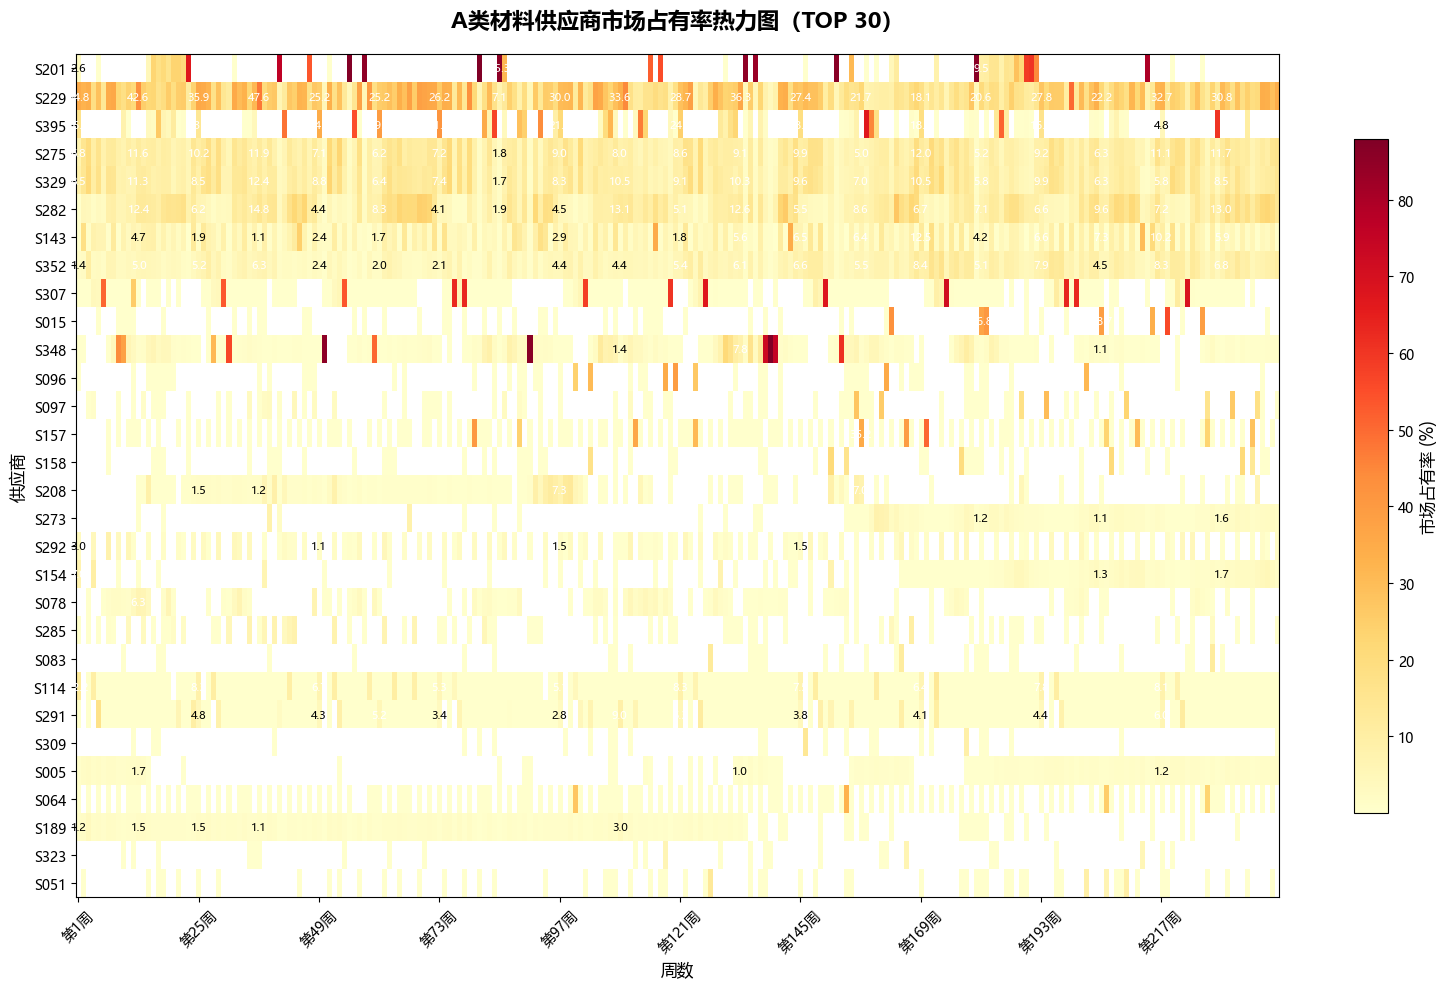

  A 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 5.80%
    - 最高市场占有率: 87.95%
    - 最高市场占有率的供应商: S348

正在绘制 B 类材料供应商市场占有率热力图...


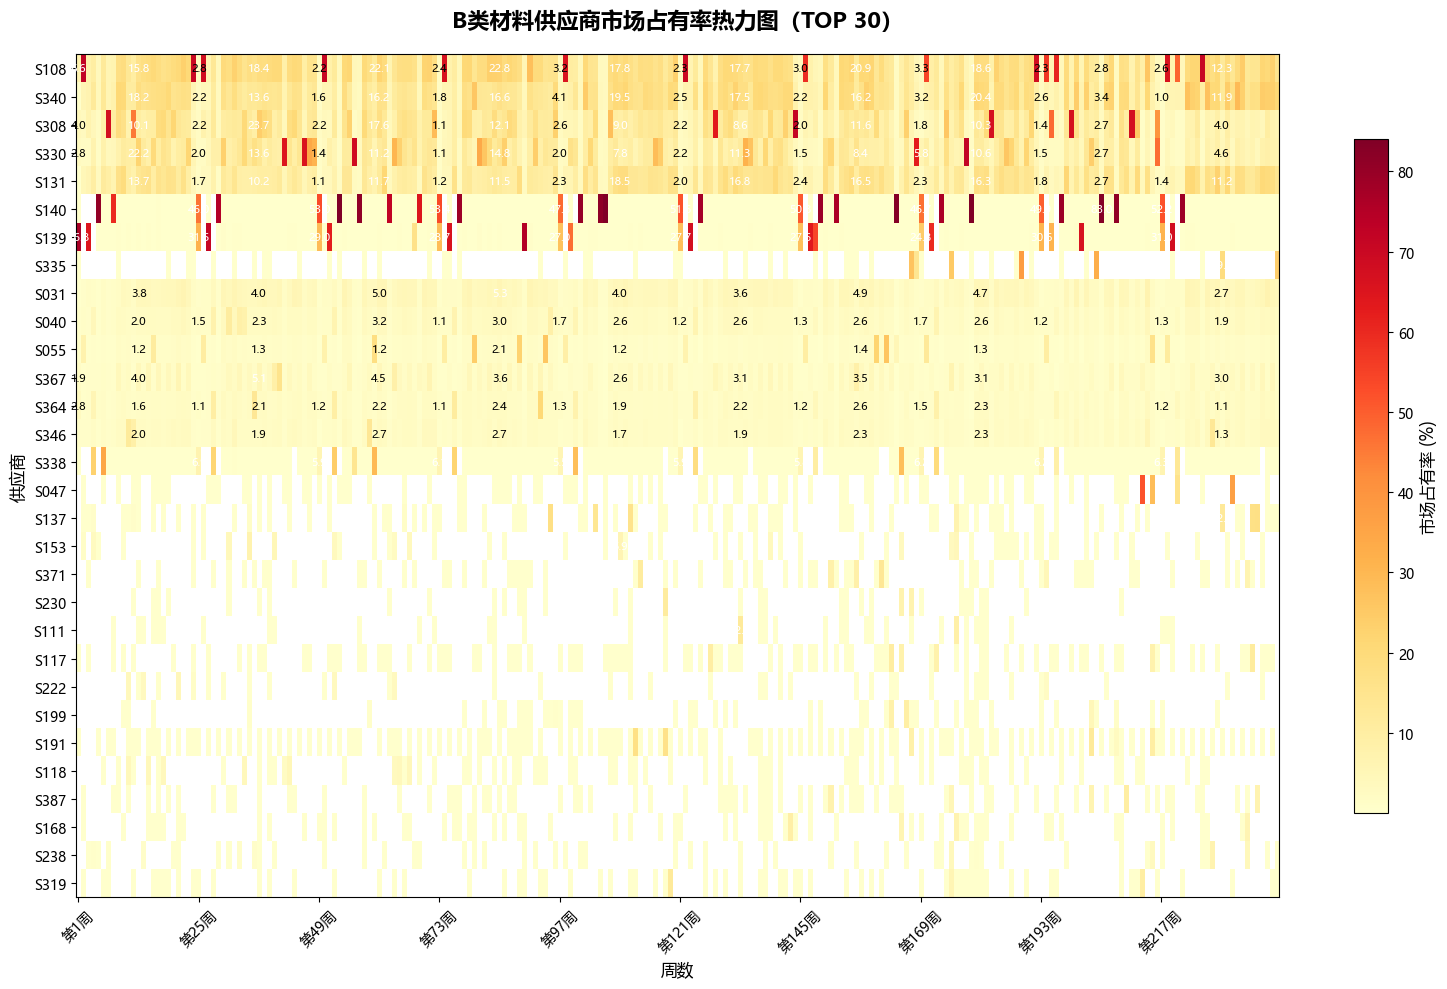

  B 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 5.32%
    - 最高市场占有率: 84.08%
    - 最高市场占有率的供应商: S140

正在绘制 C 类材料供应商市场占有率热力图...


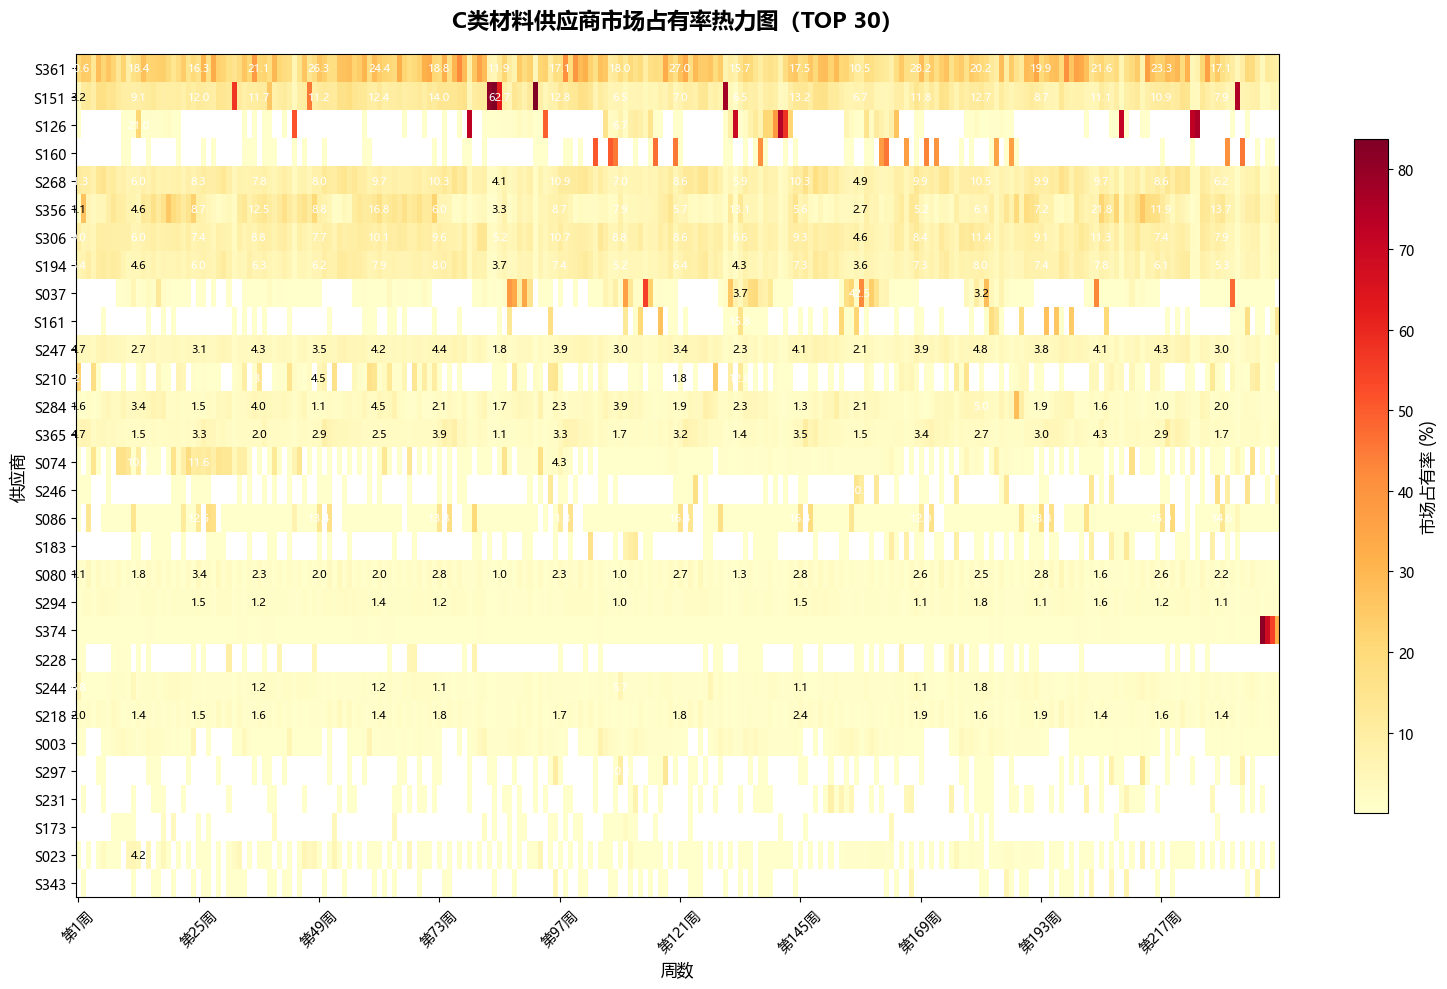

  C 类材料市场占有率统计:
    - 数据周数: 240
    - 平均市场占有率: 4.53%
    - 最高市场占有率: 83.72%
    - 最高市场占有率的供应商: S151


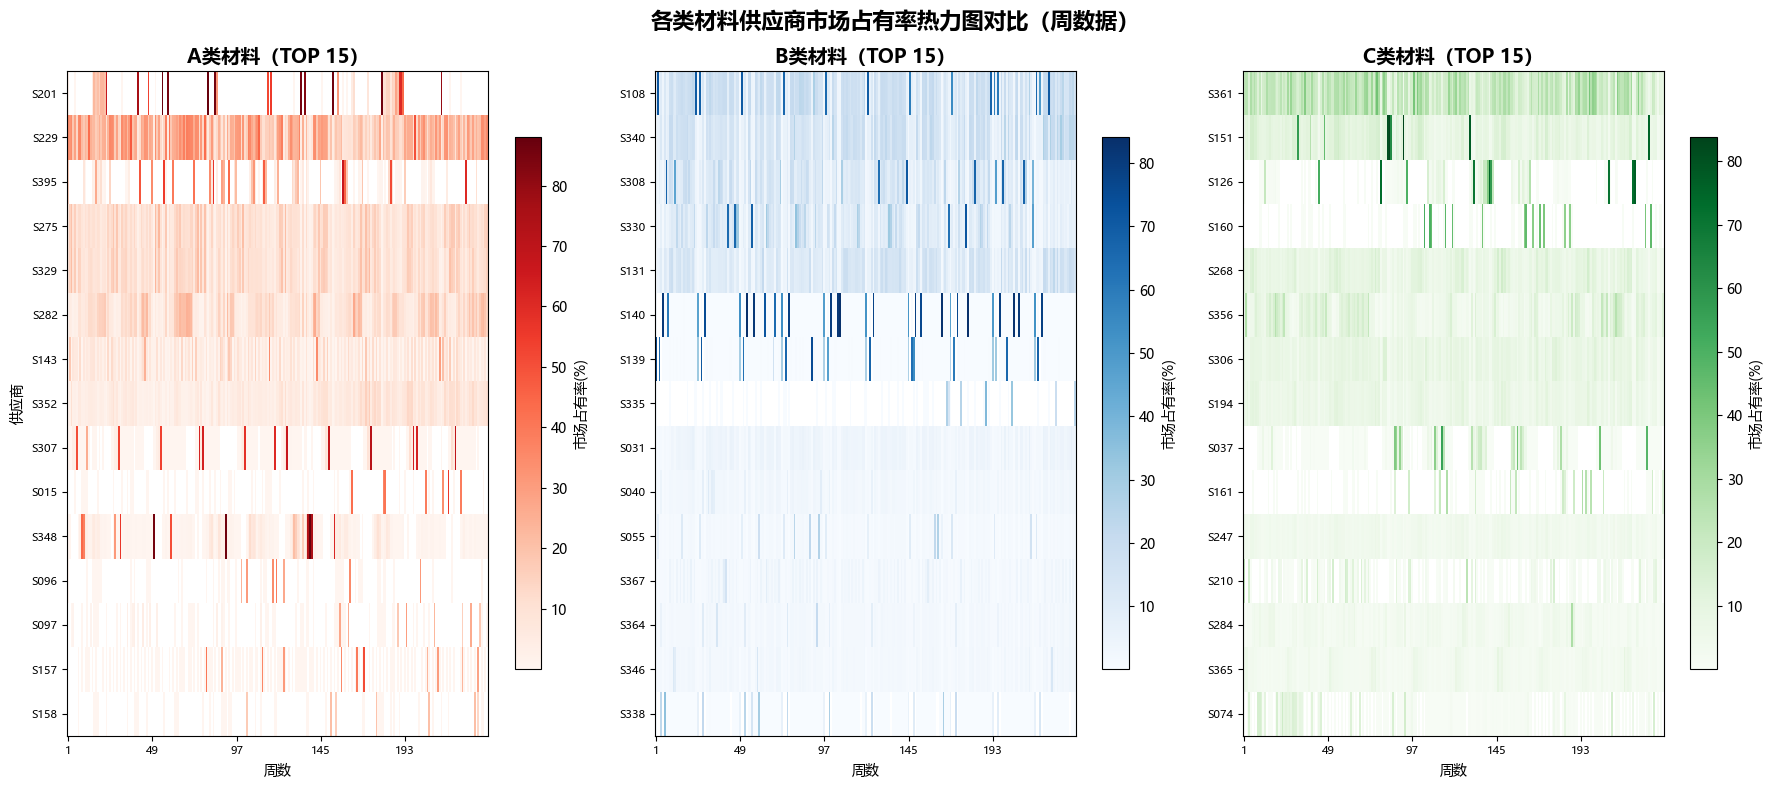


周市场占有率热力分布图绘制完成!
   已保存为SVG格式的矢量图文件

绘制年平均市场占有率热力分布图
数据分析:
  - 总周数: 240
  - 每年周数: 48
  - 完整年数: 5
  - 剩余周数: 0

正在绘制 A 类材料年平均市场占有率热力图...


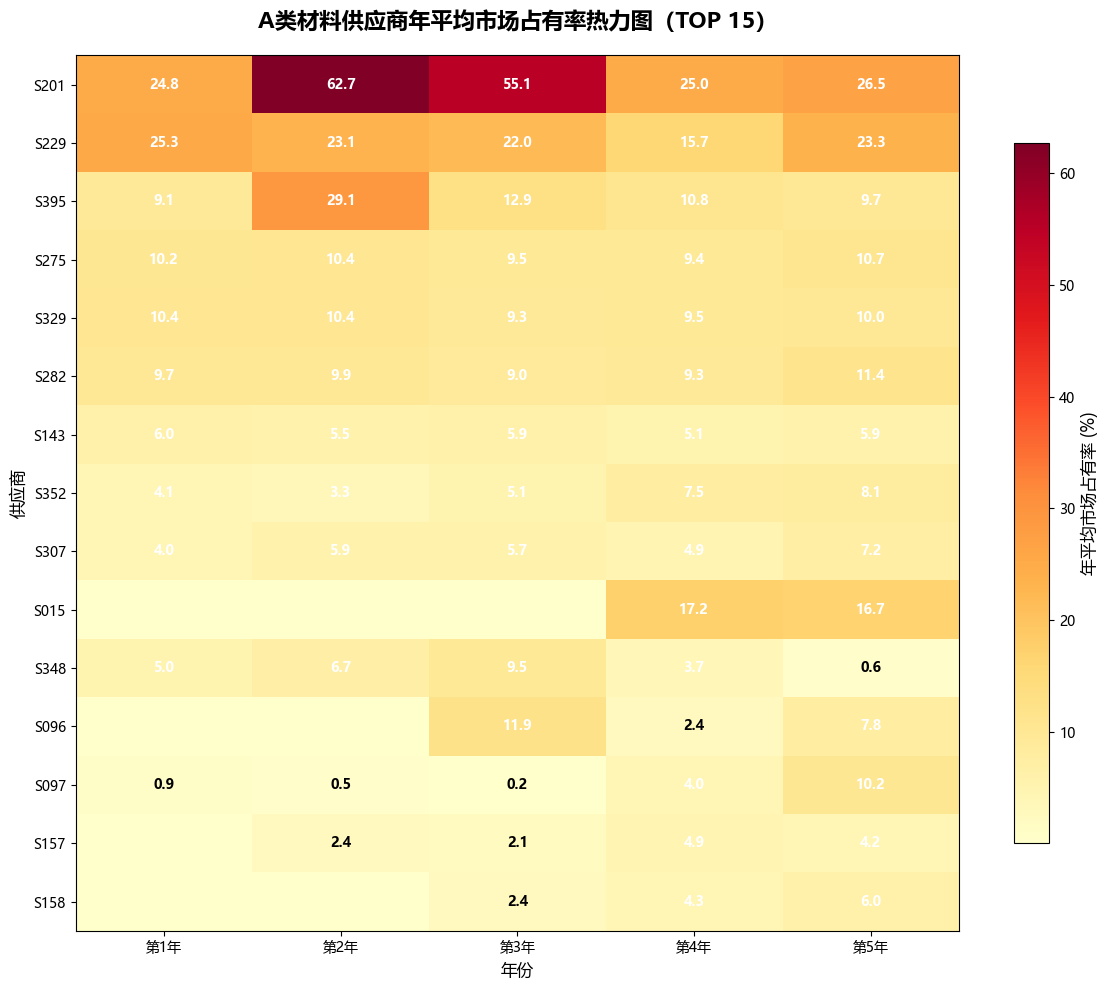

  A 类材料年度市场占有率统计:
    - 分析年数: 5
    - 平均年度市场占有率: 9.76%
    - 最高年度市场占有率: 62.71%
    - 最高表现: S201 (第2年)
    - 市场集中度变化:
      第1年 TOP5占有率: 80.5%
      第2年 TOP5占有率: 135.7%
      第3年 TOP5占有率: 111.5%
      第4年 TOP5占有率: 78.3%
      第5年 TOP5占有率: 88.6%

正在绘制 B 类材料年平均市场占有率热力图...


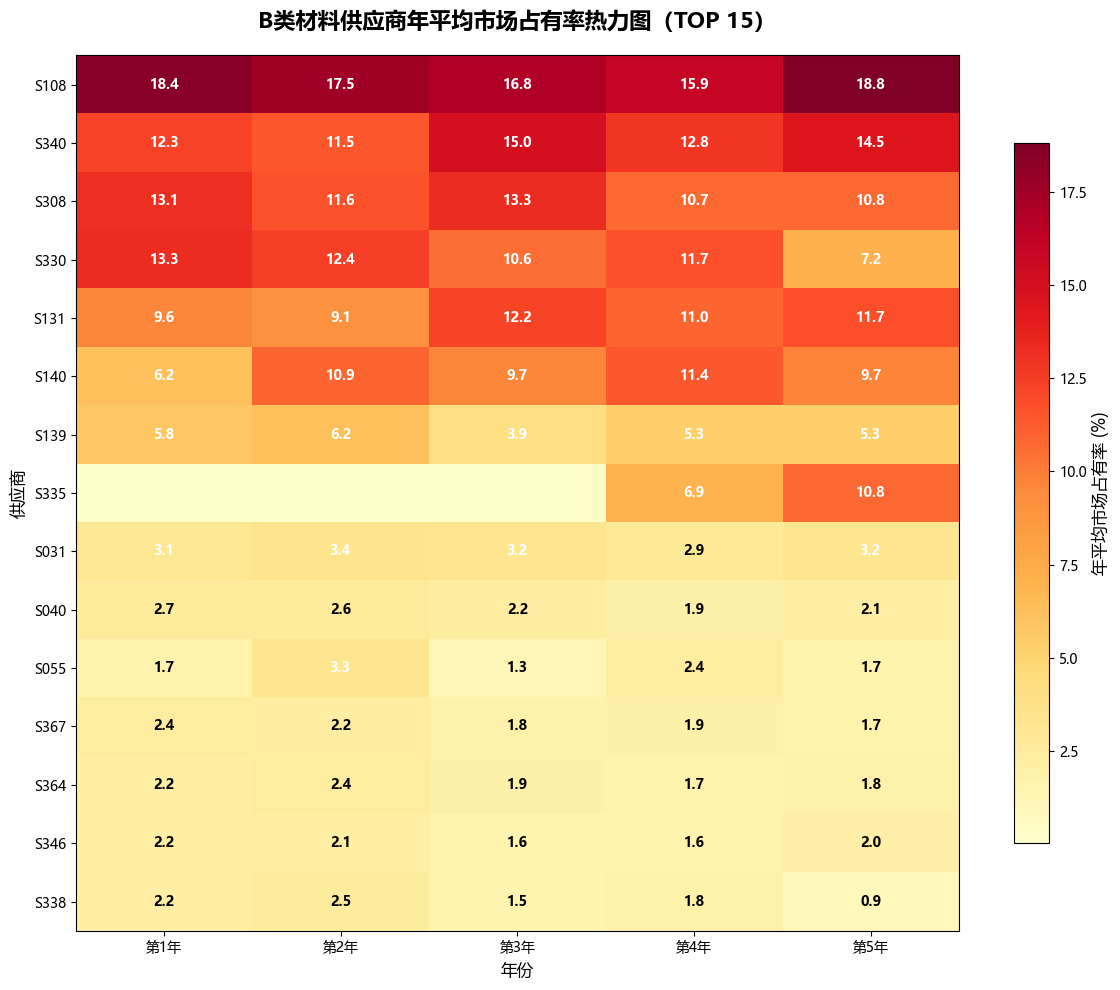

  B 类材料年度市场占有率统计:
    - 分析年数: 5
    - 平均年度市场占有率: 6.54%
    - 最高年度市场占有率: 18.81%
    - 最高表现: S108 (第5年)
    - 市场集中度变化:
      第1年 TOP5占有率: 66.8%
      第2年 TOP5占有率: 63.9%
      第3年 TOP5占有率: 67.9%
      第4年 TOP5占有率: 62.8%
      第5年 TOP5占有率: 66.7%

正在绘制 C 类材料年平均市场占有率热力图...


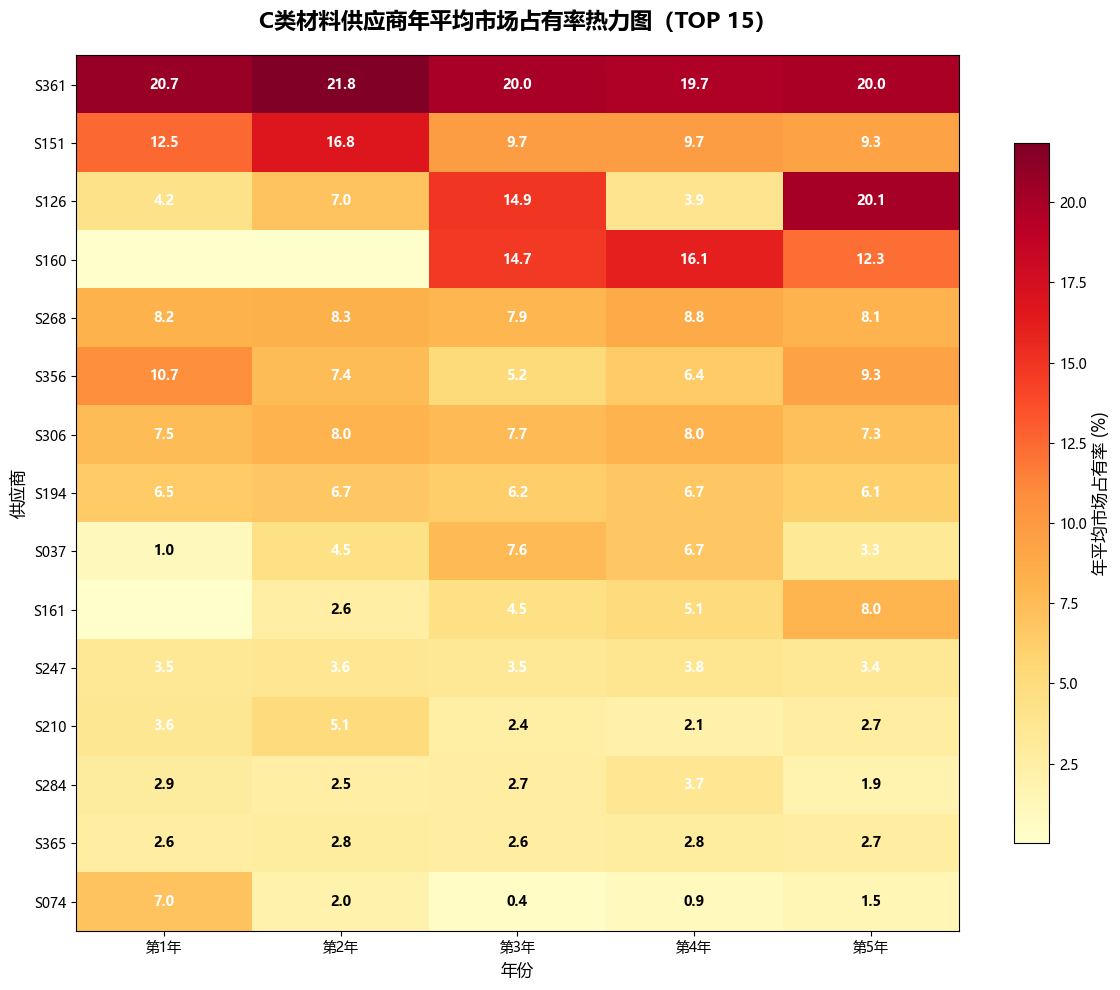

  C 类材料年度市场占有率统计:
    - 分析年数: 5
    - 平均年度市场占有率: 6.94%
    - 最高年度市场占有率: 21.85%
    - 最高表现: S361 (第2年)
    - 市场集中度变化:
      第1年 TOP5占有率: 59.6%
      第2年 TOP5占有率: 62.4%
      第3年 TOP5占有率: 67.3%
      第4年 TOP5占有率: 62.4%
      第5年 TOP5占有率: 71.0%


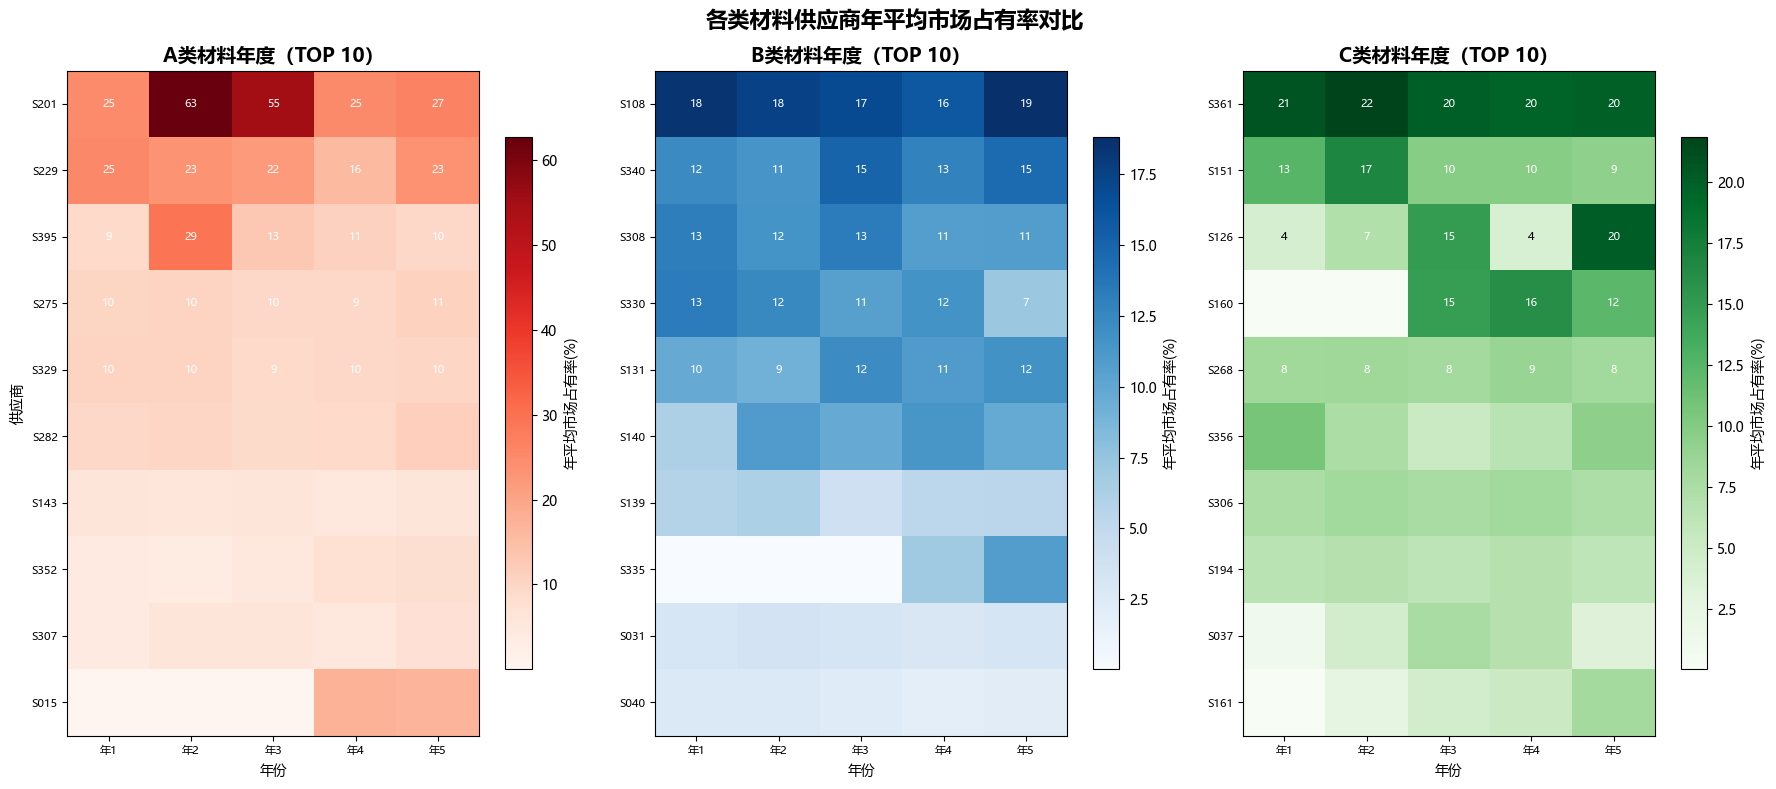


年平均市场占有率热力分布图绘制完成!
   已保存为SVG格式的矢量图文件


In [19]:

# 执行绘制函数
print("开始绘制市场占有率热力分布图...")
plot_market_share_heatmap(top_n_detail=30, top_n_comparison=15)
plot_yearly_market_share_heatmap(top_n=15)

#### 有效供货率热力图绘制


绘制有效供货率热力分布图（周数据）


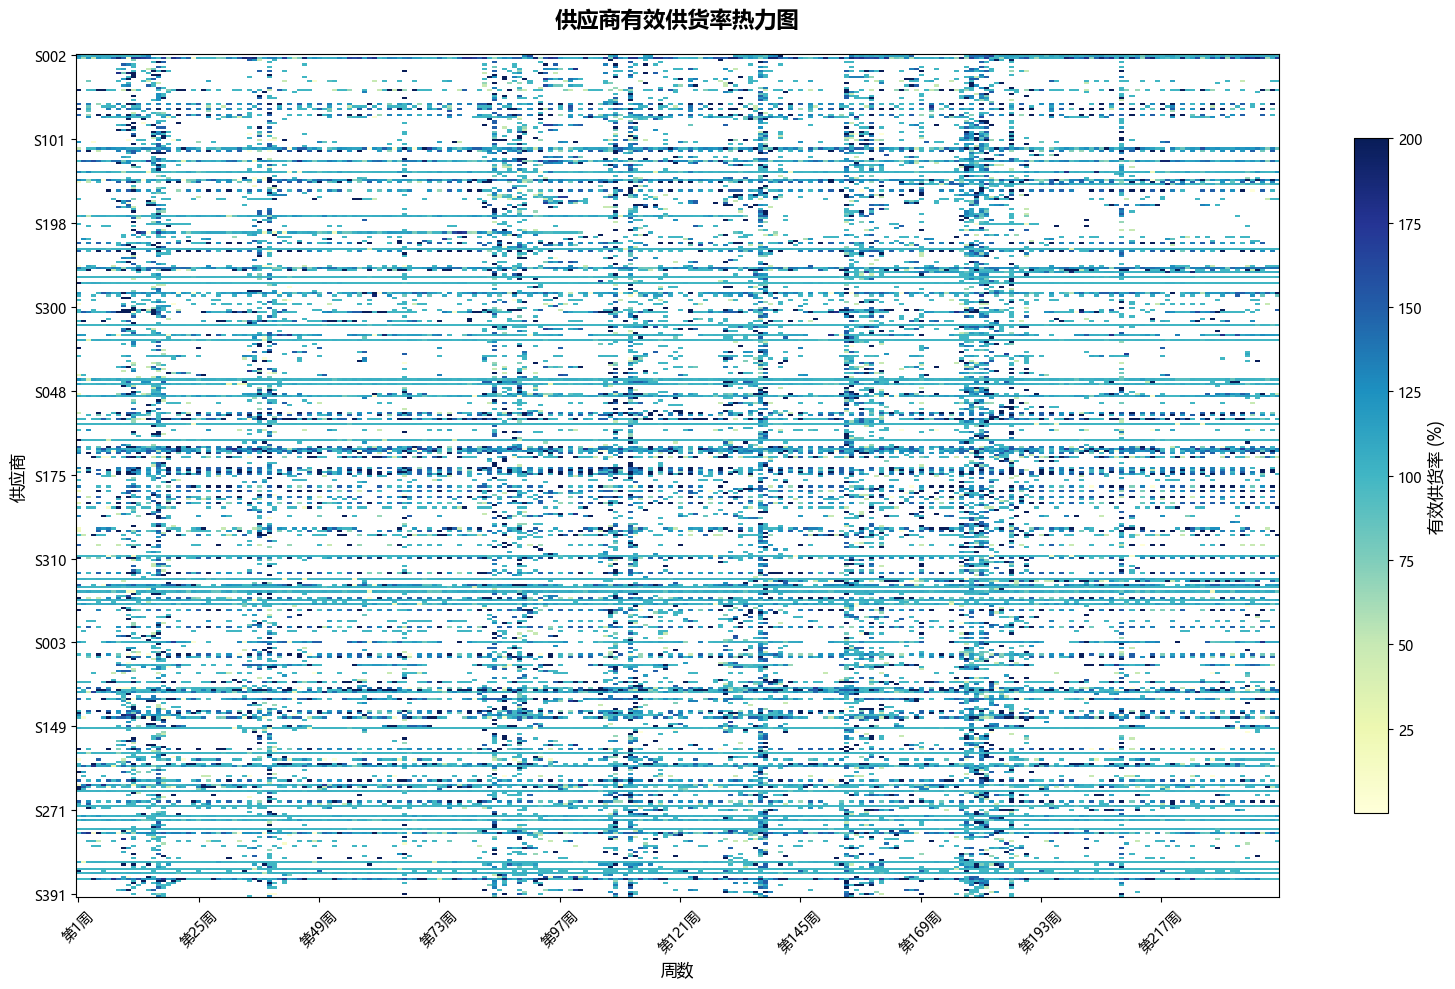

有效供货率热力分布图绘制完成！


In [20]:

import matplotlib.colors as mcolors

def plot_fulfillment_rate_heatmap():
    """
    绘制供应商有效供货率（订单满足率）热力图
    横轴为周数，纵轴为供应商，颜色为有效供货率（%），0值显示为白色
    """
    print("\n" + "="*60)
    print("绘制有效供货率热力分布图（周数据）")
    print("="*60)

    supplier_metrics_list = []
    for name, metrics in supplier_metrics.items():
        supplier_metrics_list.append({
            'supplier_name': name,
            'material_type': metrics['material_type'],
            'avg_fulfillment_rate': metrics['avg_fulfillment_rate'],
            'weekly_fulfillment_rate': metrics['weekly_fulfillment_rate']
        })
    df_metrics = pd.DataFrame(supplier_metrics_list)

    # 构建热力图数据，0值设为np.nan
    heatmap_data = np.array([np.where(x == 0, np.nan, x * 100) for x in df_metrics['weekly_fulfillment_rate']])
    supplier_names = df_metrics['supplier_name'].tolist()
    weeks = heatmap_data.shape[1]

    # 自定义colormap，NaN为白色
    cmap = plt.get_cmap('YlGnBu').copy()
    cmap.set_bad(color='white')

    plt.figure(figsize=(16, 10))
    im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')
    plt.title(f'供应商有效供货率热力图', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('周数', fontsize=12)
    plt.ylabel('供应商', fontsize=12)
    y_ticks = range(0, len(supplier_names), max(1, len(supplier_names)//10))
    plt.yticks(y_ticks, [supplier_names[i] for i in y_ticks], fontsize=10)
    x_ticks = range(0, weeks, max(1, weeks//10))
    plt.xticks(x_ticks, [f'第{i+1}周' for i in x_ticks], rotation=45, fontsize=10)
    cbar = plt.colorbar(im, shrink=0.8)
    cbar.set_label('有效供货率 (%)', fontsize=12)
    plt.tight_layout()
    plt.savefig('fulfillment_rate_heatmap.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    print("有效供货率热力分布图绘制完成！")

# 调用函数
plot_fulfillment_rate_heatmap()

### 绘制年度供货效率柱状图


绘制年度供货效率柱状图（前50名供应商）
数据分析:
  - 总周数: 240
  - 每年周数: 48
  - 完整年数: 5

前50名供应商材料类型分布:
material_type
B    21
A    16
C    13
Name: count, dtype: int64


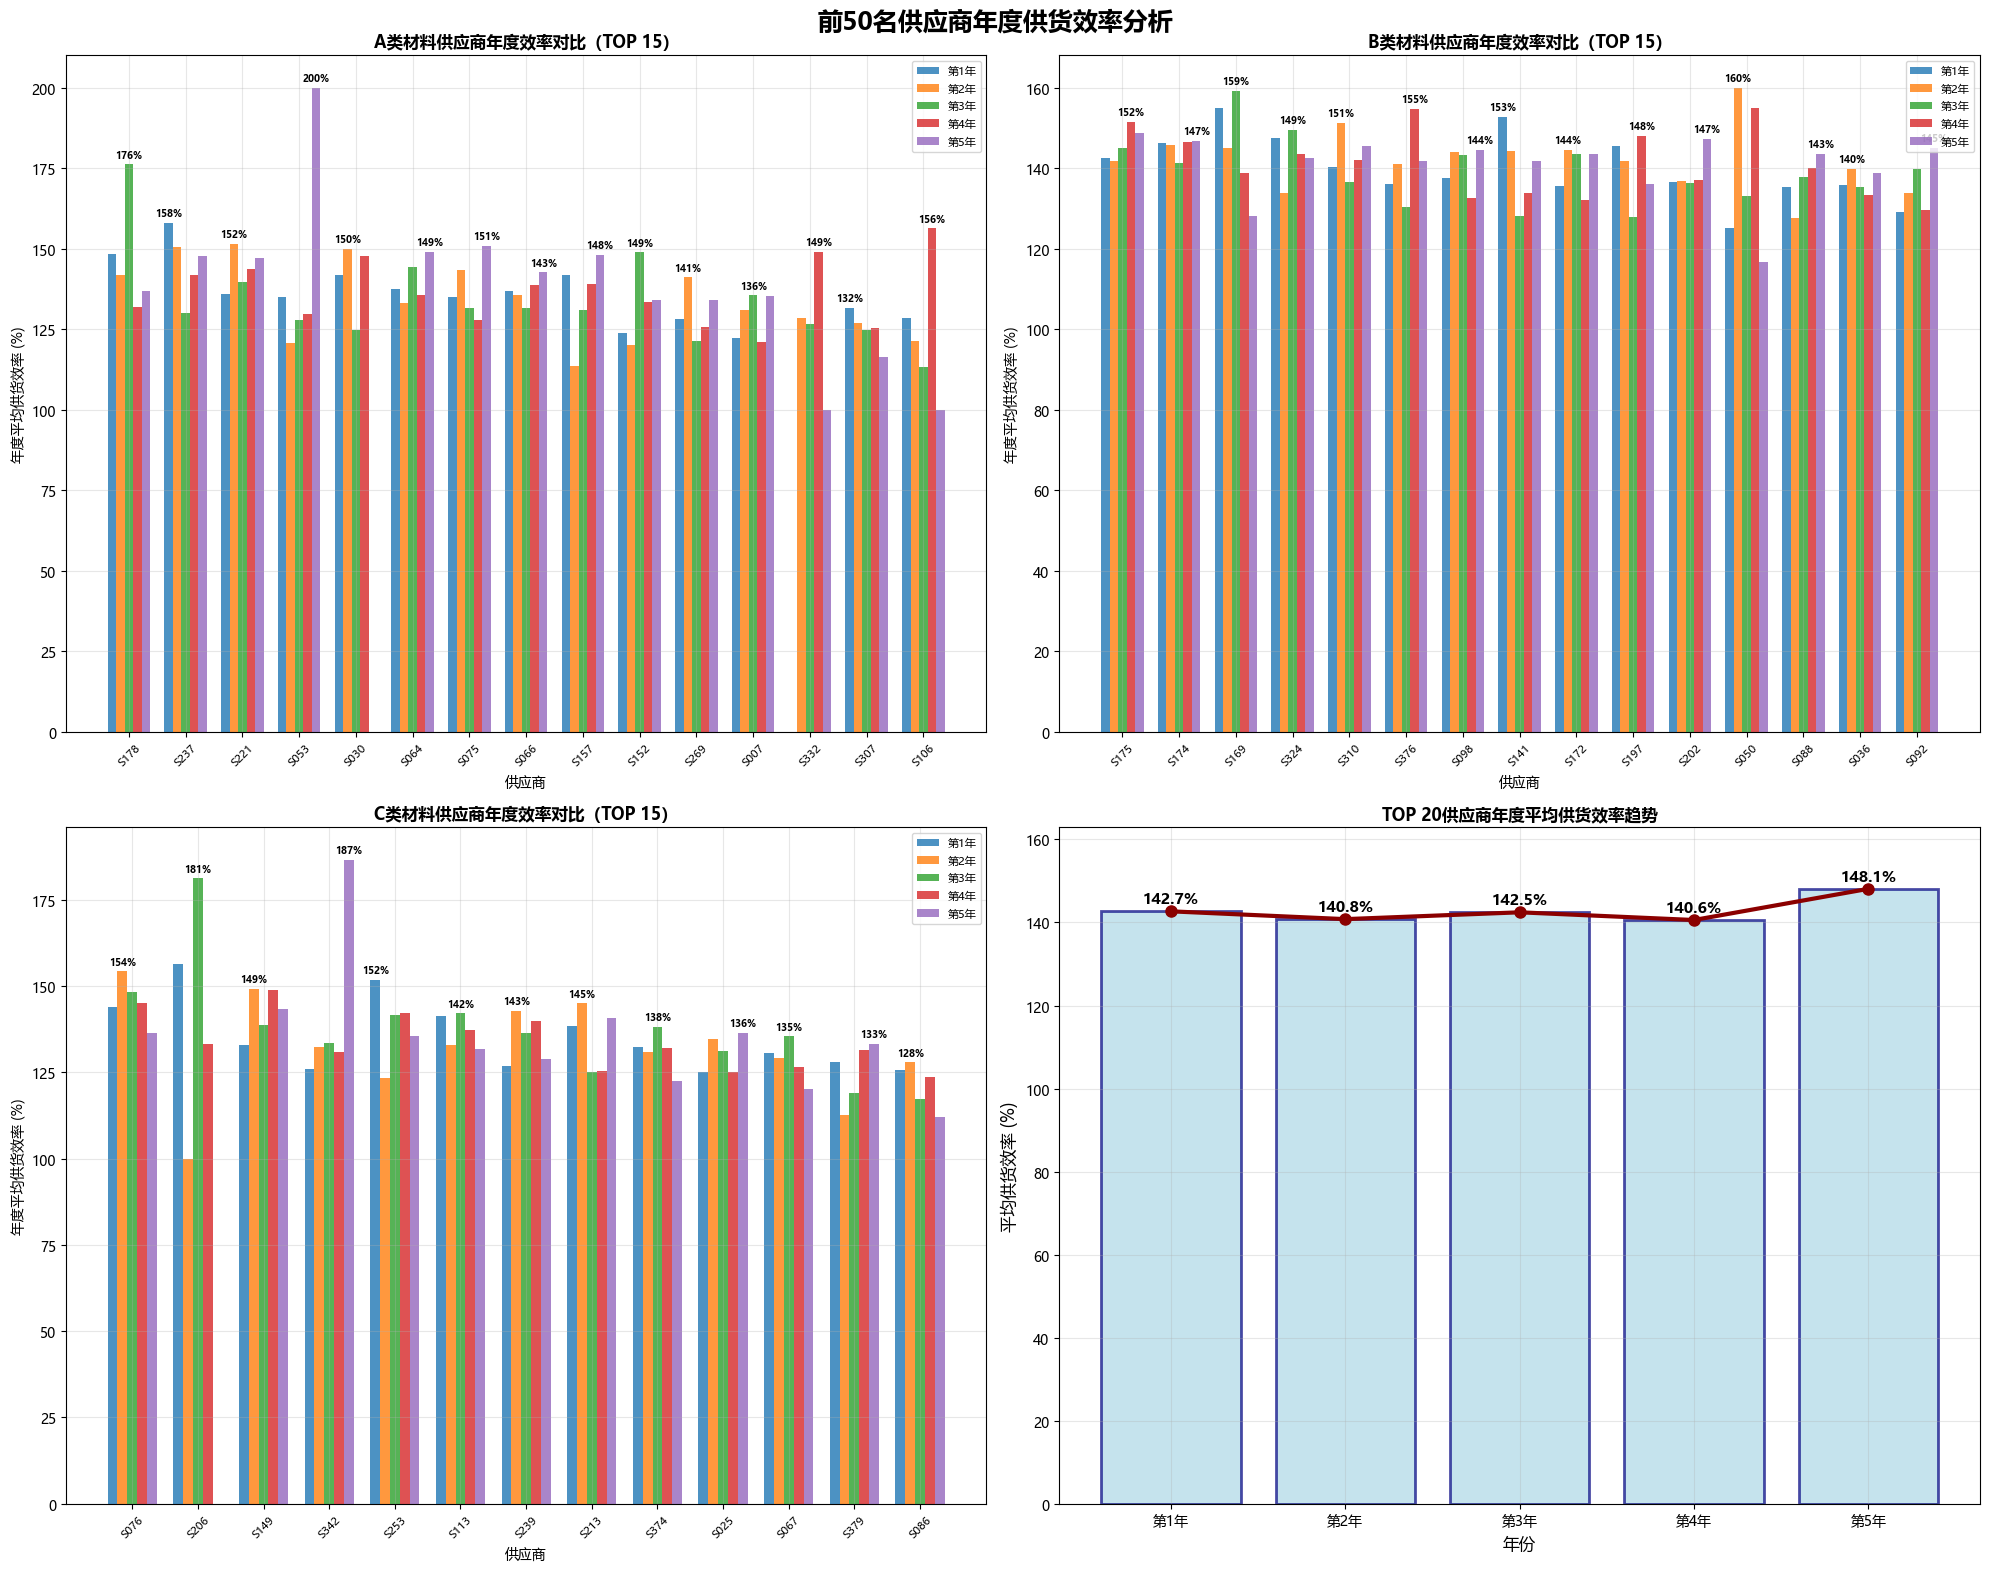


年度供货效率统计分析:
  - 分析年数: 5
  - 分析供应商数量: 50

  A类材料供应商表现:
    - 供应商数量: 16
    - 平均供货效率: 134.74%
    - 最高供货效率: 146.99%
    - 最佳供应商: S178

  B类材料供应商表现:
    - 供应商数量: 21
    - 平均供货效率: 136.90%
    - 最高供货效率: 145.89%
    - 最佳供应商: S175

  C类材料供应商表现:
    - 供应商数量: 13
    - 平均供货效率: 135.01%
    - 最高供货效率: 145.53%
    - 最佳供应商: S076

  年度效率趋势（TOP 20平均）:
    第1年: 142.69%
    第2年: 140.81%
    第3年: 142.45%
    第4年: 140.60%
    第5年: 148.11%
    整体趋势: +5.42% (提升)

年度供货效率柱状图绘制完成!
   已保存为SVG格式的矢量图文件


In [22]:
def plot_yearly_fulfillment_efficiency_bar_chart():
    """
    绘制年度供货效率柱状图（前50名供应商）
    显示每年的平均供货效率
    """
    
    print("\n" + "="*60)
    print("绘制年度供货效率柱状图（前50名供应商）")
    print("="*60)
    
    # 计算每年平均供货效率（每48周为一年）
    weeks_per_year = 48
    
    # 获取总周数
    first_supplier = list(supplier_metrics.values())[0]
    total_weeks = len(first_supplier['weekly_fulfillment_rate'])
    years = total_weeks // weeks_per_year
    
    print(f"数据分析:")
    print(f"  - 总周数: {total_weeks}")
    print(f"  - 每年周数: {weeks_per_year}")
    print(f"  - 完整年数: {years}")
    
    if years < 1:
        print("数据不足一年，无法绘制年度柱状图")
        return
    
    # 获取前50名平均供货效率最高的供应商
    supplier_list = []
    for name, metrics in supplier_metrics.items():
        supplier_list.append({
            'supplier_name': name,
            'material_type': metrics['material_type'],
            'avg_fulfillment_rate': metrics['avg_fulfillment_rate'],
            'weekly_fulfillment_rate': metrics['weekly_fulfillment_rate']
        })
    
    # 按平均供货效率排序，选取前50名
    supplier_df = pd.DataFrame(supplier_list)
    top50_suppliers = supplier_df.sort_values('avg_fulfillment_rate', ascending=False).head(50)
    
    print(f"\n前50名供应商材料类型分布:")
    print(top50_suppliers['material_type'].value_counts())
    
    # 计算前50名供应商的年度供货效率
    yearly_efficiency_data = []
    
    for _, supplier in top50_suppliers.iterrows():
        supplier_name = supplier['supplier_name']
        weekly_rates = supplier['weekly_fulfillment_rate']
        material_type = supplier['material_type']
        
        yearly_rates = []
        for year in range(years):
            start_week = year * weeks_per_year
            end_week = (year + 1) * weeks_per_year
            year_rates = weekly_rates[start_week:end_week]
            
            # 计算该年的平均供货效率（只考虑有订货的周数）
            non_zero_rates = year_rates[year_rates > 0]
            if len(non_zero_rates) > 0:
                avg_yearly_rate = np.mean(non_zero_rates)
            else:
                avg_yearly_rate = 0
            
            yearly_rates.append(avg_yearly_rate)
        
        yearly_efficiency_data.append({
            'supplier_name': supplier_name,
            'material_type': material_type,
            'yearly_rates': yearly_rates,
            'overall_avg': np.mean([r for r in yearly_rates if r > 0])
        })
    
    # 按材料类型分组绘制柱状图
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('前50名供应商年度供货效率分析', fontsize=18, fontweight='bold')
    
    # 准备数据
    material_colors = {'A': '#FF6B6B', 'B': '#4ECDC4', 'C': '#45B7D1'}
    year_labels = [f'第{i+1}年' for i in range(years)]
    
    # 1. 各类材料供应商年度效率对比
    for idx, material in enumerate(['A', 'B', 'C']):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        # 筛选该材料类型的供应商
        material_data = [data for data in yearly_efficiency_data if data['material_type'] == material]
        if not material_data:
            ax.set_title(f'{material}类材料：无数据')
            continue
        
        # 选择前15名该材料类型的供应商
        material_data = sorted(material_data, key=lambda x: x['overall_avg'], reverse=True)[:15]
        
        # 准备绘图数据
        x_pos = np.arange(len(material_data))
        bar_width = 0.15
        
        # 为每年创建一组柱状图
        for year in range(years):
            year_values = [data['yearly_rates'][year] * 100 for data in material_data]  # 转为百分比
            ax.bar(x_pos + year * bar_width, year_values, bar_width, 
                   label=f'第{year+1}年', alpha=0.8)
        
        ax.set_xlabel('供应商', fontsize=10)
        ax.set_ylabel('年度平均供货效率 (%)', fontsize=10)
        ax.set_title(f'{material}类材料供应商年度效率对比（TOP 15）', fontsize=12, fontweight='bold')
        ax.set_xticks(x_pos + bar_width * (years-1) / 2)
        ax.set_xticklabels([data['supplier_name'][:6] for data in material_data], rotation=45, fontsize=8)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # 显示数值（只在最高的柱子上显示）
        for i, data in enumerate(material_data):
            max_rate = max(data['yearly_rates']) * 100
            if max_rate > 80:  # 只在高效率的供应商上显示数值
                max_year = data['yearly_rates'].index(max(data['yearly_rates']))
                ax.text(i + max_year * bar_width, max_rate + 1, f'{max_rate:.0f}%', 
                       ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # 4. 整体TOP 20供应商年度效率趋势
    ax = axes[1, 1]
    
    # 选择总体前20名供应商
    top20_overall = sorted(yearly_efficiency_data, key=lambda x: x['overall_avg'], reverse=True)[:20]
    
    # 计算每年的平均效率
    yearly_avg_efficiency = []
    for year in range(years):
        year_rates = [data['yearly_rates'][year] for data in top20_overall if data['yearly_rates'][year] > 0]
        yearly_avg_efficiency.append(np.mean(year_rates) * 100 if year_rates else 0)
    
    # 绘制趋势线
    bars = ax.bar(year_labels, yearly_avg_efficiency, color='lightblue', alpha=0.7, edgecolor='navy', linewidth=2)
    ax.plot(range(years), yearly_avg_efficiency, 'ro-', linewidth=3, markersize=8, color='darkred')
    
    # 添加数值标签
    for i, v in enumerate(yearly_avg_efficiency):
        ax.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_xlabel('年份', fontsize=12)
    ax.set_ylabel('平均供货效率 (%)', fontsize=12)
    ax.set_title('TOP 20供应商年度平均供货效率趋势', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max(yearly_avg_efficiency) * 1.1)
    
    plt.tight_layout()
    plt.savefig('yearly_fulfillment_efficiency_top50.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 输出统计信息
    print(f"\n年度供货效率统计分析:")
    print(f"  - 分析年数: {years}")
    print(f"  - 分析供应商数量: 50")
    
    # 各材料类型统计
    for material in ['A', 'B', 'C']:
        material_suppliers = [data for data in yearly_efficiency_data if data['material_type'] == material]
        if material_suppliers:
            avg_efficiency = np.mean([data['overall_avg'] for data in material_suppliers]) * 100
            max_efficiency = max([data['overall_avg'] for data in material_suppliers]) * 100
            best_supplier = max(material_suppliers, key=lambda x: x['overall_avg'])
            
            print(f"\n  {material}类材料供应商表现:")
            print(f"    - 供应商数量: {len(material_suppliers)}")
            print(f"    - 平均供货效率: {avg_efficiency:.2f}%")
            print(f"    - 最高供货效率: {max_efficiency:.2f}%")
            print(f"    - 最佳供应商: {best_supplier['supplier_name']}")
    
    # 年度趋势分析
    print(f"\n  年度效率趋势（TOP 20平均）:")
    for year, efficiency in enumerate(yearly_avg_efficiency):
        print(f"    第{year+1}年: {efficiency:.2f}%")
    
    # 计算效率变化趋势
    if len(yearly_avg_efficiency) > 1:
        trend = yearly_avg_efficiency[-1] - yearly_avg_efficiency[0]
        print(f"    整体趋势: {'+' if trend > 0 else ''}{trend:.2f}% {'(提升)' if trend > 0 else '(下降)' if trend < 0 else '(稳定)'}")
    
    print("\n年度供货效率柱状图绘制完成!")
    print("   已保存为SVG格式的矢量图文件")

# 调用函数绘制年度供货效率柱状图
plot_yearly_fulfillment_efficiency_bar_chart()

## 后面写的啥还没看

In [ ]:
print("供应商供货特征统计:")
print(f"  总体可靠性分布:")
print(f"    - 平均可靠性: {supplier_analysis['reliability'].mean():.3f}")
print(f"    - 可靠性中位数: {supplier_analysis['reliability'].median():.3f}")
print(f"    - 可靠性标准差: {supplier_analysis['reliability'].std():.3f}")

print(f"\n各类材料供应商特征对比:")
for material in ['A', 'B', 'C']:
    material_suppliers = supplier_analysis[supplier_analysis['material_type'] == material]
    print(f"    {material}类材料 ({len(material_suppliers)}家):")
    print(f"      - 平均可靠性: {material_suppliers['reliability'].mean():.3f}")
    print(f"      - 平均供货频率: {material_suppliers['supply_frequency'].mean():.3f}")
    print(f"      - 平均周供货量: {material_suppliers['avg_weekly_supply'].mean():.1f} m³")
    print(f"      - 总供货能力: {material_suppliers['total_supply'].sum():.0f} m³")

# 显示表现最好的供应商
print(f"\n各类材料表现最佳的前5名供应商:")
for material in ['A', 'B', 'C']:
    print(f"\n{material}类材料:")
    material_suppliers = supplier_analysis[supplier_analysis['material_type'] == material]
    top_suppliers = material_suppliers.nlargest(5, 'total_supply')
    
    for idx, (_, supplier) in enumerate(top_suppliers.iterrows(), 1):
        print(f"  {idx}. {supplier['supplier_name']}: "
              f"总供货量{supplier['total_supply']:.0f}m³, "
              f"可靠性{supplier['reliability']:.3f}, "
              f"供货频率{supplier['supply_frequency']:.3f}")

In [ ]:
# ==================== 附件2转运商数据分析 ====================
print("\n" + "="*60)
print("步骤4：附件2转运商数据分析")
print("="*60)

print("转运商数据结构:")
print(transporter_loss.head())

# 提取转运商数据
transporter_names = transporter_loss.iloc[:, 0].values  # 转运商名称
loss_data = transporter_loss.iloc[:, 1:].values        # 损耗率数据

print(f"\n转运商基本信息:")
print(f"  - 转运商总数: {len(transporter_names)}")
print(f"  - 数据周期: {loss_data.shape[1]} 周")
print(f"  - 转运商列表: {list(transporter_names)}")

# 分析每个转运商的损耗率特征
def analyze_transporter_characteristics():
    """分析转运商损耗率特征"""
    
    transporter_metrics = []
    
    for i, name in enumerate(transporter_names):
        losses = loss_data[i]
        
        # 过滤非零损耗率
        non_zero_losses = losses[losses > 0]
        
        # 计算关键指标
        avg_loss_rate = np.mean(non_zero_losses) if len(non_zero_losses) > 0 else 0
        median_loss_rate = np.median(non_zero_losses) if len(non_zero_losses) > 0 else 0
        min_loss_rate = np.min(non_zero_losses) if len(non_zero_losses) > 0 else 0
        max_loss_rate = np.max(non_zero_losses) if len(non_zero_losses) > 0 else 0
        std_loss_rate = np.std(non_zero_losses) if len(non_zero_losses) > 0 else 0
        
        # 损耗率稳定性 (变异系数)
        cv_loss_rate = std_loss_rate / avg_loss_rate if avg_loss_rate > 0 else 0
        
        # 运输频率
        transport_frequency = len(non_zero_losses) / len(losses)
        
        transporter_metrics.append({
            'transporter_name': name,
            'avg_loss_rate': avg_loss_rate,
            'median_loss_rate': median_loss_rate,
            'min_loss_rate': min_loss_rate,
            'max_loss_rate': max_loss_rate,
            'std_loss_rate': std_loss_rate,
            'cv_loss_rate': cv_loss_rate,
            'transport_frequency': transport_frequency,
            'active_weeks': len(non_zero_losses)
        })
    
    return pd.DataFrame(transporter_metrics)

# 计算转运商特征
transporter_analysis = analyze_transporter_characteristics()

print(f"\n转运商损耗率特征分析:")
print(f"  整体损耗率统计:")
print(f"    - 平均损耗率: {transporter_analysis['avg_loss_rate'].mean():.3f}%")
print(f"    - 损耗率范围: {transporter_analysis['min_loss_rate'].min():.3f}% - {transporter_analysis['max_loss_rate'].max():.3f}%")
print(f"    - 损耗率标准差: {transporter_analysis['avg_loss_rate'].std():.3f}%")

print(f"\n各转运商详细表现:")
# 按平均损耗率排序
transporter_ranking = transporter_analysis.sort_values('avg_loss_rate')

for idx, (_, transporter) in enumerate(transporter_ranking.iterrows(), 1):
    print(f"  {idx}. {transporter['transporter_name']}:")
    print(f"     平均损耗率: {transporter['avg_loss_rate']:.3f}%")
    print(f"     损耗率范围: {transporter['min_loss_rate']:.3f}% - {transporter['max_loss_rate']:.3f}%")
    print(f"     稳定性(CV): {transporter['cv_loss_rate']:.3f}")
    print(f"     运输频率: {transporter['transport_frequency']:.3f}")

# 转运商分类
print(f"\n转运商性能分类:")
low_loss = transporter_ranking[transporter_ranking['avg_loss_rate'] < 1.0]
medium_loss = transporter_ranking[(transporter_ranking['avg_loss_rate'] >= 1.0) & 
                                  (transporter_ranking['avg_loss_rate'] < 2.0)]
high_loss = transporter_ranking[transporter_ranking['avg_loss_rate'] >= 2.0]

print(f"  低损耗率转运商 (<1.0%): {list(low_loss['transporter_name'])}")
print(f"  中等损耗率转运商 (1.0%-2.0%): {list(medium_loss['transporter_name'])}")
print(f"  高损耗率转运商 (>2.0%): {list(high_loss['transporter_name'])}")

print(f"\n转运商选择建议:")
print(f"  推荐优先使用: {list(low_loss['transporter_name'][:3])}")
print(f"  备选方案: {list(medium_loss['transporter_name'][:2])}")

In [ ]:
# ==================== 数据可视化分析 ====================
print("\n" + "="*60)
print("步骤5：数据可视化分析")
print("="*60)

# 创建综合分析图表
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('附件1和附件2数据综合分析', fontsize=16, fontweight='bold')

# 1. 供应商材料类型分布
material_counts = supplier_analysis['material_type'].value_counts()
axes[0, 0].pie(material_counts.values, labels=material_counts.index, autopct='%1.1f%%', 
               colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('供应商材料类型分布')

# 2. 供应商可靠性分布
axes[0, 1].hist(supplier_analysis['reliability'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('供货可靠性')
axes[0, 1].set_ylabel('供应商数量')
axes[0, 1].set_title('供应商可靠性分布')
axes[0, 1].axvline(supplier_analysis['reliability'].mean(), color='red', linestyle='--', 
                   label=f'平均值: {supplier_analysis["reliability"].mean():.3f}')
axes[0, 1].legend()

# 3. 各类材料供应商表现对比
material_reliability = supplier_analysis.groupby('material_type')['reliability'].mean()
axes[0, 2].bar(material_reliability.index, material_reliability.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 2].set_xlabel('材料类型')
axes[0, 2].set_ylabel('平均可靠性')
axes[0, 2].set_title('各类材料供应商平均可靠性')
for i, v in enumerate(material_reliability.values):
    axes[0, 2].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 4. 转运商损耗率排名
transporter_sorted = transporter_analysis.sort_values('avg_loss_rate')
axes[1, 0].bar(range(len(transporter_sorted)), transporter_sorted['avg_loss_rate'], 
               color='lightcoral')
axes[1, 0].set_xlabel('转运商排名')
axes[1, 0].set_ylabel('平均损耗率 (%)')
axes[1, 0].set_title('转运商损耗率排名')
axes[1, 0].set_xticks(range(len(transporter_sorted)))
axes[1, 0].set_xticklabels(transporter_sorted['transporter_name'], rotation=45)

# 5. 供应商总供货量分布
axes[1, 1].scatter(supplier_analysis['total_supply'], supplier_analysis['reliability'],
                   c=supplier_analysis['material_type'].map({'A': 'red', 'B': 'blue', 'C': 'green'}),
                   alpha=0.6, s=50)
axes[1, 1].set_xlabel('总供货量 (m³)')
axes[1, 1].set_ylabel('供货可靠性')
axes[1, 1].set_title('供应商供货量vs可靠性')
axes[1, 1].legend(['A类', 'B类', 'C类'])

# 6. 转运商损耗率vs稳定性
axes[1, 2].scatter(transporter_analysis['avg_loss_rate'], transporter_analysis['cv_loss_rate'],
                   s=100, alpha=0.7, color='orange')
axes[1, 2].set_xlabel('平均损耗率 (%)')
axes[1, 2].set_ylabel('损耗率变异系数')
axes[1, 2].set_title('转运商损耗率vs稳定性')

# 为每个点添加标签
for i, name in enumerate(transporter_analysis['transporter_name']):
    axes[1, 2].annotate(name, 
                        (transporter_analysis.iloc[i]['avg_loss_rate'], 
                         transporter_analysis.iloc[i]['cv_loss_rate']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

print("可视化分析完成！")
print("主要发现:")
print(f"  1. 供应商可靠性差异较大，平均值为 {supplier_analysis['reliability'].mean():.3f}")
print(f"  2. 转运商损耗率范围: {transporter_analysis['avg_loss_rate'].min():.3f}% - {transporter_analysis['avg_loss_rate'].max():.3f}%")
print(f"  3. 最优转运商: {transporter_sorted.iloc[0]['transporter_name']} (损耗率: {transporter_sorted.iloc[0]['avg_loss_rate']:.3f}%)")
print(f"  4. 各类材料供应商数量基本均衡，但表现存在差异")

In [ ]:
# ==================== 数据分析总结与建议 ====================
print("\n" + "="*60)
print("步骤6：数据分析总结与战略建议")
print("="*60)

# 生成供应商重要性排名
def calculate_supplier_importance_score(supplier_analysis):
    """计算供应商重要性综合评分"""
    
    # 标准化各项指标
    scaler_metrics = supplier_analysis.copy()
    
    # 归一化处理
    scaler_metrics['norm_total_supply'] = (scaler_metrics['total_supply'] - scaler_metrics['total_supply'].min()) / (scaler_metrics['total_supply'].max() - scaler_metrics['total_supply'].min())
    scaler_metrics['norm_reliability'] = scaler_metrics['reliability']
    scaler_metrics['norm_stability'] = (scaler_metrics['stability'] - scaler_metrics['stability'].min()) / (scaler_metrics['stability'].max() - scaler_metrics['stability'].min())
    scaler_metrics['norm_frequency'] = scaler_metrics['supply_frequency']
    
    # 材料类型权重 (A类最重要，价格最高)
    material_weights = {'A': 1.2, 'B': 1.1, 'C': 1.0}
    scaler_metrics['material_weight'] = scaler_metrics['material_type'].map(material_weights)
    
    # 综合评分 (总供货量40% + 可靠性30% + 稳定性15% + 频率10% + 材料类型5%)
    scaler_metrics['importance_score'] = (
        0.40 * scaler_metrics['norm_total_supply'] +
        0.30 * scaler_metrics['norm_reliability'] +
        0.15 * scaler_metrics['norm_stability'] +
        0.10 * scaler_metrics['norm_frequency'] +
        0.05 * scaler_metrics['material_weight']
    )
    
    return scaler_metrics.sort_values('importance_score', ascending=False)

# 计算供应商重要性排名
supplier_ranking = calculate_supplier_importance_score(supplier_analysis)

print("TOP 20 最重要供应商排名:")
print("-" * 80)
print(f"{'排名':<4} {'供应商':<12} {'类型':<4} {'总供货量':<10} {'可靠性':<8} {'重要性评分':<10}")
print("-" * 80)

for i in range(min(20, len(supplier_ranking))):
    supplier = supplier_ranking.iloc[i]
    print(f"{i+1:<4} {supplier['supplier_name']:<12} {supplier['material_type']:<4} "
          f"{supplier['total_supply']:<10.0f} {supplier['reliability']:<8.3f} "
          f"{supplier['importance_score']:<10.3f}")

# 转运商最优选择策略
transporter_optimal = transporter_analysis.sort_values(['avg_loss_rate', 'cv_loss_rate'])

print(f"\n转运商最优选择策略:")
print(f"  推荐使用顺序 (按损耗率+稳定性):")
for i, transporter in enumerate(transporter_optimal.iterrows(), 1):
    name = transporter[1]['transporter_name']
    loss_rate = transporter[1]['avg_loss_rate']
    stability = transporter[1]['cv_loss_rate']
    print(f"    {i}. {name}: 损耗率{loss_rate:.3f}%, 稳定性{stability:.3f}")

print(f"\n关键数据洞察:")
print(f"  附件1 - 供应商数据:")
print(f"    总计402家供应商，分布相对均衡")
print(f"    平均供货可靠性: {supplier_analysis['reliability'].mean():.1%}")
print(f"    供货可靠性标准差: {supplier_analysis['reliability'].std():.3f} (差异较大)")
print(f"    A类供应商表现相对较好，平均可靠性: {supplier_analysis[supplier_analysis['material_type']=='A']['reliability'].mean():.1%}")

print(f"\n附件2 - 转运商数据:")
print(f"    总计8家转运商，损耗率差异显著")
print(f"    最低损耗率: {transporter_analysis['avg_loss_rate'].min():.3f}% (T3)")
print(f"    最高损耗率: {transporter_analysis['avg_loss_rate'].max():.3f}% (T5)")
print(f"    损耗率范围: {transporter_analysis['avg_loss_rate'].max() - transporter_analysis['avg_loss_rate'].min():.3f}%")

print(f"\n战略建议:")
print(f"  供应商管理:")
print(f"    1. 重点合作前50名供应商，覆盖各类材料")
print(f"    2. 建立供应商分级管理体系")
print(f"    3. 针对低可靠性供应商制定改进计划")
print(f"    4. 平衡各类材料供应商数量和能力")

print(f"\n转运商选择:")
print(f"    1. 优先选择T3、T6、T2等低损耗率转运商")
print(f"    2. 建立转运商绩效监控机制")
print(f"    3. 与多家转运商保持合作关系确保供应安全")
print(f"    4. 考虑损耗率和稳定性的综合评估")

print(f"\n风险管控:")
print(f"    1. 建立供应商和转运商备选方案")
print(f"    2. 定期评估供应商表现并动态调整")
print(f"    3. 制定应急预案应对供应中断")

print(f"\n" + "="*60)
print("附件1和附件2数据分析完成！")
print("数据已为后续问题求解提供了坚实基础。")
print("="*60)